# ✈️ US Flight Delay Analysis & Prediction

## 1. Project Overview

### Objective
To explore the feasibility of predicting flight delay rates based on aggregated historical data using Machine Learning techniques.

### Hypothesis
We assume that a portion of flight delays is systematic (driven by seasonality, carrier efficiency, and airport congestion) and can be effectively predicted.

> ⚠️ **Research Limitations (Disclaimer)**
> It is crucial to acknowledge the **stochastic nature** of air transportation. A significant portion of delays is caused by factors absent from this dataset (e.g., local weather anomalies, specific aircraft technical issues, cascading network delays).
> **Goal:** The objective is not to achieve a perfect metric, but to extract the maximum predictable signal from the available data and determine the theoretical limits of predictability.

### Datasets
1.  **Primary Data:** US domestic flights over 10 years (2013-2023).
    * *Source:* [Flight Delay Data](https://www.kaggle.com/datasets/sriharshaeedala/airline-delay/data)
2.  **Auxiliary Data:** Geospatial data (coordinates) for US airports used for visualization.
    * *Source:* [List of US Airports](https://www.kaggle.com/datasets/aravindram11/list-of-us-airports/data)

---

## 2. Data Loading & Initial Inspection

In [1]:
import datetime as dt
import os
from pathlib import Path
import warnings

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import shap
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    TargetEncoder, 
    StandardScaler, 
    PolynomialFeatures
)
from sklearn.model_selection import (
    RandomizedSearchCV, 
    GridSearchCV, 
    PredefinedSplit, 
    learning_curve
)
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error
)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

%load_ext watermark
%watermark -a "aelarisq" -u -d -v -p pandas,numpy,xgboost,sklearn,scipy,matplotlib,seaborn,plotly,shap,statsmodels

Author: aelarisq

Last updated: 2025-12-17

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 9.8.0

pandas     : 2.3.3
numpy      : 1.26.4
xgboost    : 3.1.2
sklearn    : 1.5.2
scipy      : 1.16.3
matplotlib : 3.10.8
seaborn    : 0.13.2
plotly     : 6.5.0
shap       : 0.49.1
statsmodels: 0.14.6



In [2]:
def set_seed(seed: int = 42):

    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    print(f"Random seed set to {seed}")

SEED = 42
RANDOM_STATE = 42
set_seed(SEED)

Random seed set to 42


In [3]:
air_delays_df= pd.read_csv(Path("data") / "Airline_Delay_Cause.csv")

print(f"Dataset shape: {air_delays_df.shape}")
display(air_delays_df.head())

air_delays_df.info()
print(f"\nNumber of duplicate values: {air_delays_df.duplicated().sum()}")

Dataset shape: (171666, 21)


year  month carrier       carrier_name airport  \
0  2023      8      9E  Endeavor Air Inc.     ABE   
1  2023      8      9E  Endeavor Air Inc.     ABY   
2  2023      8      9E  Endeavor Air Inc.     AEX   
3  2023      8      9E  Endeavor Air Inc.     AGS   
4  2023      8      9E  Endeavor Air Inc.     ALB   

                                        airport_name  arr_flights  arr_del15  \
0  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...         89.0       13.0   
1             Albany, GA: Southwest Georgia Regional         62.0       10.0   
2           Alexandria, LA: Alexandria International         62.0       10.0   
3        Augusta, GA: Augusta Regional at Bush Field         66.0       12.0   
4                   Albany, NY: Albany International         92.0       22.0   

   carrier_ct  weather_ct  nas_ct  security_ct  late_aircraft_ct  \
0        2.25        1.60    3.16          0.0              5.99   
1        1.97        0.04    0.57          0.0              7.42   
2        2.73        1.18    1.80          0.0              4.28   
3        3.69        2.27    4.47          0.0              1.57   
4        7.76        0.00    2.96          0.0             11.28   

   arr_cancelled  arr_diverted  arr_delay  carrier_delay  weather_delay  \
0            2.0           1.0     1375.0           71.0          761.0   
1            0.0           1.0      799.0          218.0            1.0   
2            1.0           0.0      766.0           56.0          188.0   
3            1.0           1.0     1397.0          471.0          320.0   
4            2.0           0.0     1530.0          628.0            0.0   

   nas_delay  security_delay  late_aircraft_delay  
0      118.0             0.0                425.0  
1       62.0             0.0                518.0  
2       78.0             0.0                444.0  
3      388.0             0.0                218.0  
4      134.0             0.0                768.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171666 entries, 0 to 171665
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 171666 non-null  int64  
 1   month                171666 non-null  int64  
 2   carrier              171666 non-null  object 
 3   carrier_name         171666 non-null  object 
 4   airport              171666 non-null  object 
 5   airport_name         171666 non-null  object 
 6   arr_flights          171426 non-null  float64
 7   arr_del15            171223 non-null  float64
 8   carrier_ct           171426 non-null  float64
 9   weather_ct           171426 non-null  float64
 10  nas_ct               171426 non-null  float64
 11  security_ct          171426 non-null  float64
 12  late_aircraft_ct     171426 non-null  float64
 13  arr_cancelled        171426 non-null  float64
 14  arr_diverted         171426 non-null  float64
 15  arr_delay        

**Dataset Structure:**
* **Dimensions:** 171,666 rows × 21 columns.
* **Data Types:** Predominantly numerical features.
* **Integrity:** No duplicates found.
* **Missing Values:** Detected in delay-related columns (e.g., `arr_del15`, `arr_delay`), accounting for < 1% of the data

### Data Cleaning

In [4]:
air_delays_df.isnull().mean() * 100

year                   0.000000
month                  0.000000
carrier                0.000000
carrier_name           0.000000
airport                0.000000
airport_name           0.000000
arr_flights            0.139806
arr_del15              0.258059
carrier_ct             0.139806
weather_ct             0.139806
nas_ct                 0.139806
security_ct            0.139806
late_aircraft_ct       0.139806
arr_cancelled          0.139806
arr_diverted           0.139806
arr_delay              0.139806
carrier_delay          0.139806
weather_delay          0.139806
nas_delay              0.139806
security_delay         0.139806
late_aircraft_delay    0.139806
dtype: float64

Since the missing data constitutes a negligible portion of the dataset, we will drop these rows. This approach ensures we train on factual data without introducing bias through imputation

In [5]:
print(f"Original shape: {air_delays_df.shape}")
air_delays_df.dropna(inplace=True)
print(f"Shape after cleaning: {air_delays_df.shape}")

Original shape: (171666, 21)
Shape after cleaning: (171223, 21)


### Target Creation

In [6]:
air_delays_df["delay_rate"] = air_delays_df["arr_del15"] / air_delays_df["arr_flights"]
air_delays_df[['arr_flights', 'arr_del15', 'delay_rate']].head(10)

arr_flights  arr_del15  delay_rate
0         89.0       13.0    0.146067
1         62.0       10.0    0.161290
2         62.0       10.0    0.161290
3         66.0       12.0    0.181818
4         92.0       22.0    0.239130
5       1636.0      256.0    0.156479
6         75.0       12.0    0.160000
7         59.0        7.0    0.118644
8         62.0       13.0    0.209677
9         30.0        4.0    0.133333

We define the target variable `delay_rate` as the ratio of delayed flights to total arrived flights:
$$\text{Delay Rate} = \frac{\text{arr\_del15}}{\text{arr\_flights}}$$
This provides a relative measure of performance (probability of delay)

---

## 3. Exploratory Data Analysis (EDA)

**Objective:**
Investigate the underlying patterns of flight delays to inform feature engineering and model selection

### 3.1 Target Variable Analysis (`delay_rate`)

In [7]:
air_delays_df["delay_rate"].describe().T

count    171223.000000
mean          0.183365
std           0.110349
min           0.000000
25%           0.109890
50%           0.170732
75%           0.241528
max           1.000000
Name: delay_rate, dtype: float64

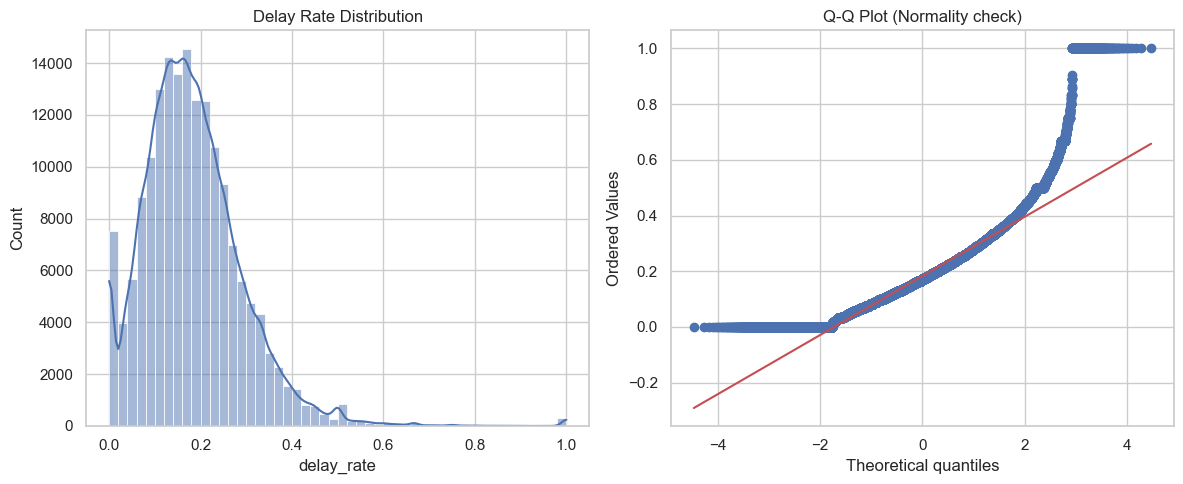

In [8]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(ax=axs[0], data=air_delays_df["delay_rate"], kde=True, bins=50)
axs[0].set_title("Delay Rate Distribution")

stats.probplot(air_delays_df["delay_rate"], dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot (Normality check)")

plt.tight_layout()
plt.show()

In [9]:
suspicious_airports = air_delays_df[air_delays_df["delay_rate"] >= 0.60]
print(f"Values where delay rate >= 60%: {len(suspicious_airports)}")
print(f"Average flights for this values: {suspicious_airports["arr_flights"].mean():.1f}")

Values where delay rate >= 60%: 805
Average flights for this values: 13.0


* **Distribution:** Heavily right-skewed. While most airports maintain a low delay rate ($0.0 - 0.35$), there are extreme outliers ($> 0.40$)
* **Normality:** The Q-Q plot shows significant deviation from the normal distribution with heavy right tails

**Insight:**
Extreme delay rates are often associated with small airports (e.g., an airport with only 2 flights/month, both delayed, yields a 100% rate). This "small sample size" noise suggests that the target might benefit from smoothing (shrinkage) during the modeling phase

### 3.2 Key Numerical Features

**Objective:**
To investigate the distribution of all numerical features and check for skewness or potential outliers

In [10]:
air_delays_df.describe().T

count         mean           std     min         25%  \
year                 171223.0  2018.549739      2.891314  2013.0  2016.00000   
month                171223.0     6.495284      3.441753     1.0     3.00000   
arr_flights          171223.0   362.946427    993.408638     1.0    50.00000   
arr_del15            171223.0    66.434387    179.540694     0.0     6.00000   
carrier_ct           171223.0    20.821272     50.339895     0.0     2.17000   
weather_ct           171223.0     2.253015      7.318176     0.0     0.00000   
nas_ct               171223.0    19.404125     61.708181     0.0     1.00000   
security_ct          171223.0     0.157283      0.717809     0.0     0.00000   
late_aircraft_ct     171223.0    23.798736     72.431750     0.0     1.24000   
arr_cancelled        171223.0     7.527686     43.676378     0.0     0.00000   
arr_diverted         171223.0     0.864300      3.774970     0.0     0.00000   
arr_delay            171223.0  4244.513617  12625.199210     0.0   336.00000   
carrier_delay        171223.0  1438.889034   4217.885488     0.0   111.00000   
weather_delay        171223.0   222.827365    821.537321     0.0     0.00000   
nas_delay            171223.0   921.743218   3425.391326     0.0    35.00000   
security_delay       171223.0     7.391478     41.803971     0.0     0.00000   
late_aircraft_delay  171223.0  1653.658299   5224.663092     0.0    66.00000   
delay_rate           171223.0     0.183365      0.110349     0.0     0.10989   

                             50%          75%        max  
year                 2019.000000  2021.000000    2023.00  
month                   7.000000     9.000000      12.00  
arr_flights           101.000000   250.000000   21977.00  
arr_del15              17.000000    47.000000    4176.00  
carrier_ct              6.410000    17.300000    1293.91  
weather_ct              0.400000     1.860000     266.42  
nas_ct                  3.930000    11.730000    1884.42  
security_ct             0.000000     0.000000      58.69  
late_aircraft_ct        5.000000    15.280000    2069.07  
arr_cancelled           1.000000     4.000000    4951.00  
arr_diverted            0.000000     1.000000     197.00  
arr_delay            1020.000000  2888.500000  438783.00  
carrier_delay         375.000000  1110.000000  196944.00  
weather_delay          18.000000   146.000000   31960.00  
nas_delay             147.000000   478.000000  112018.00  
security_delay          0.000000     0.000000    3760.00  
late_aircraft_delay   321.000000  1072.000000  227959.00  
delay_rate              0.170732     0.241528       1.00

All numerical features have a strongly right-skewed distribution, so applying a logarithmic transformation helps reduce skewness and makes the results more interpretable

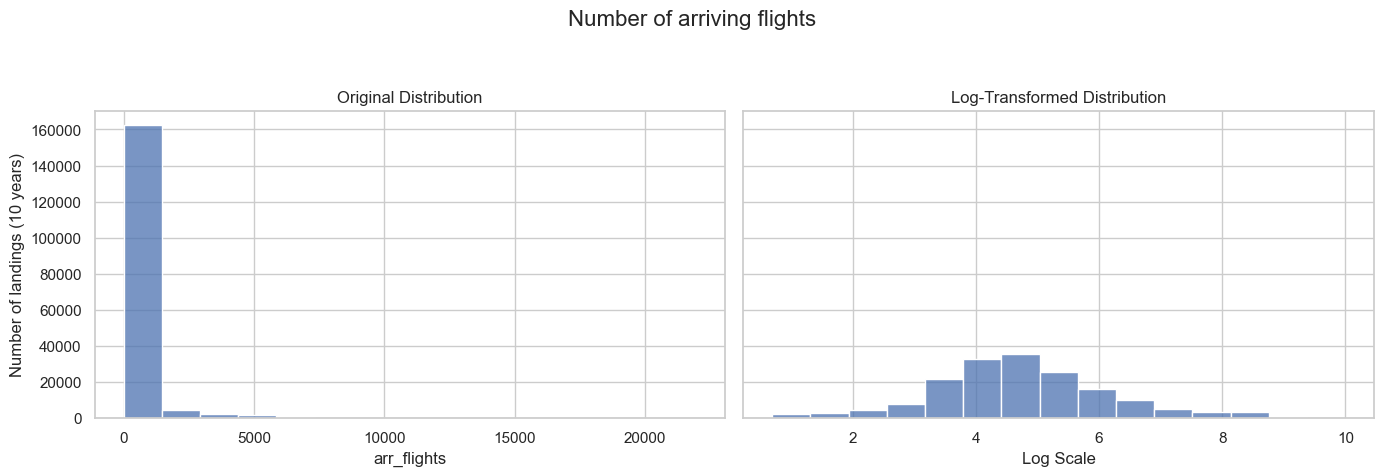

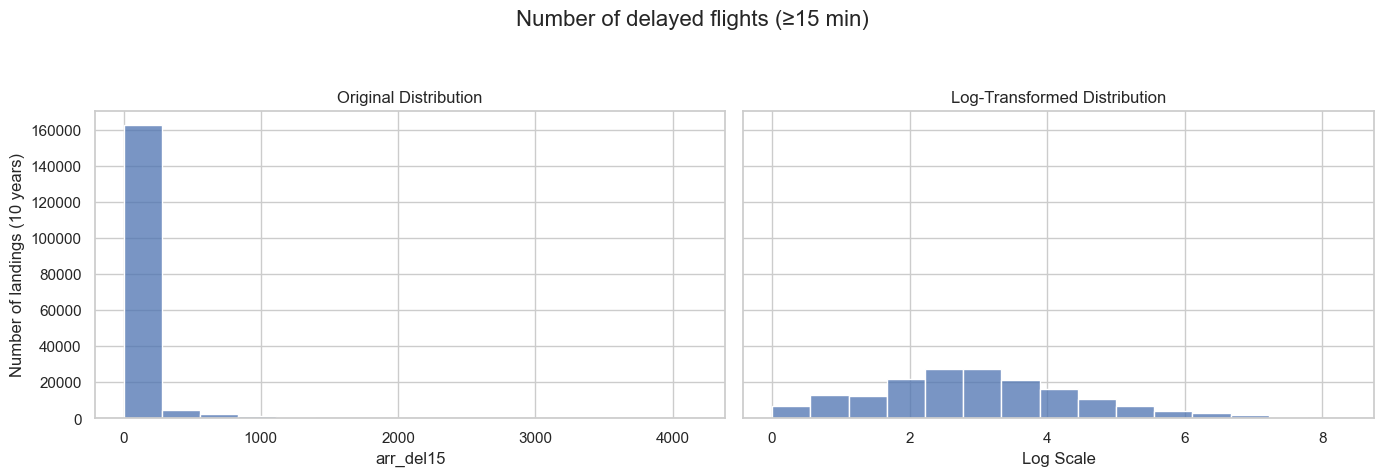

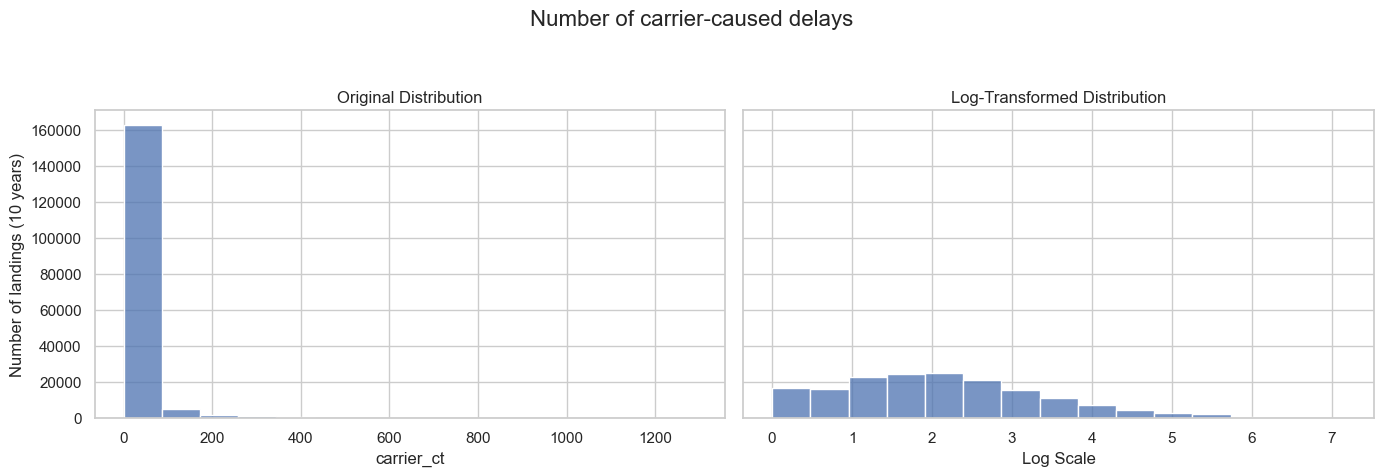

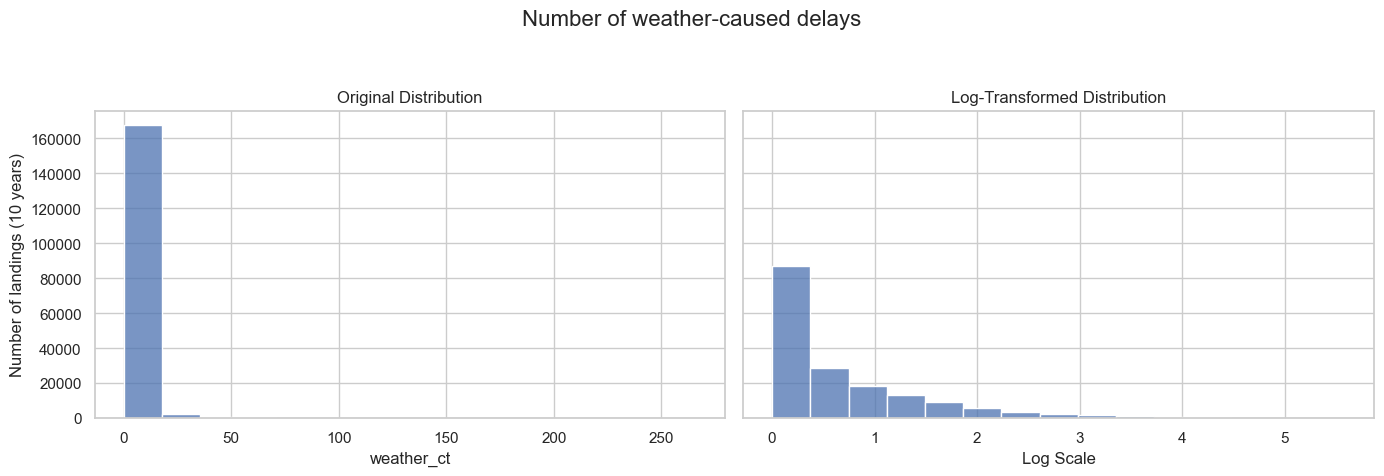

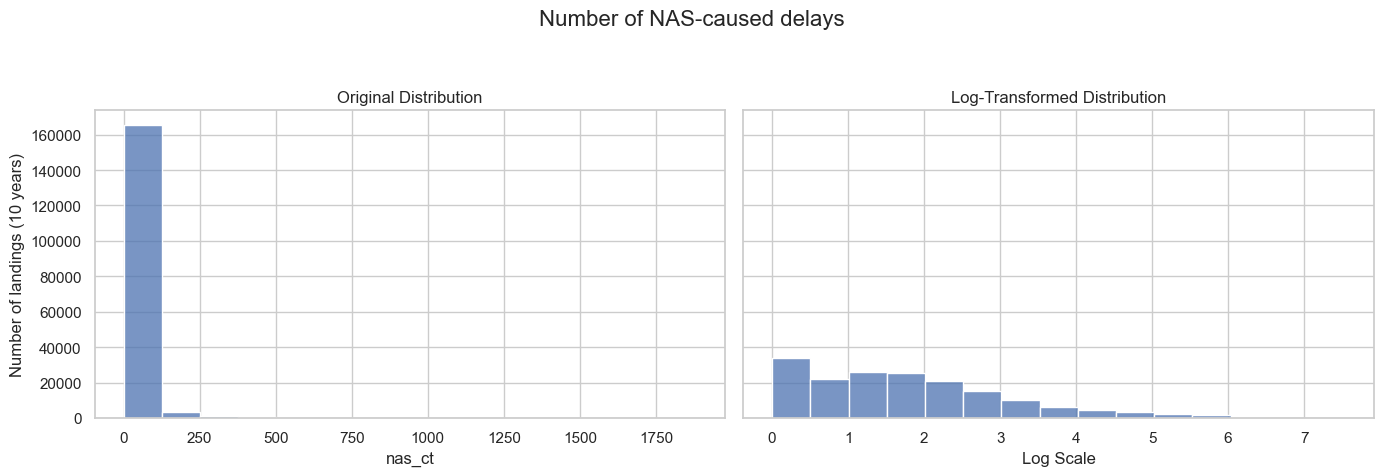

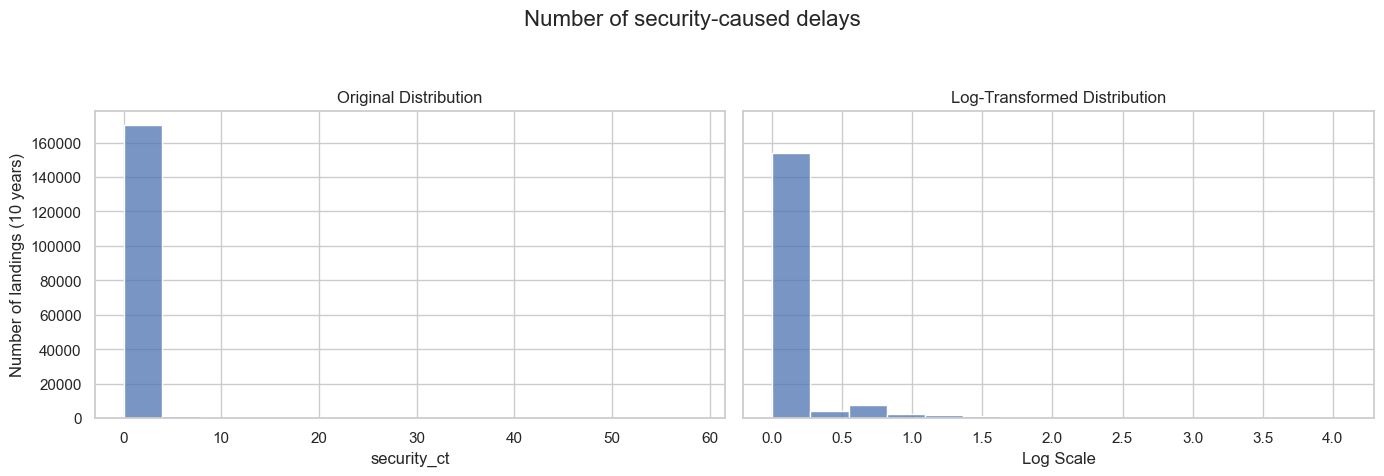

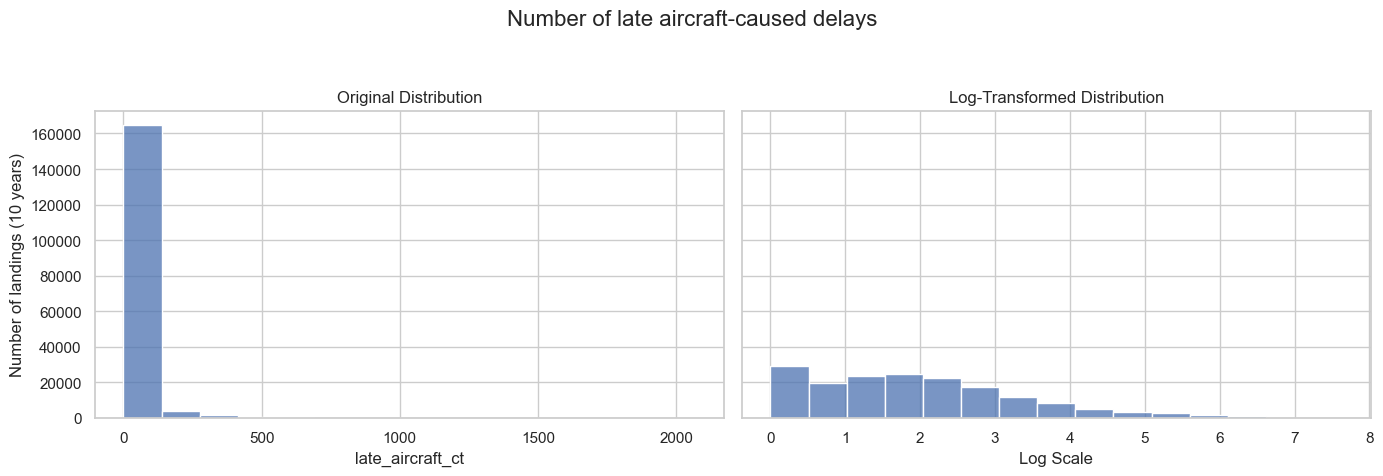

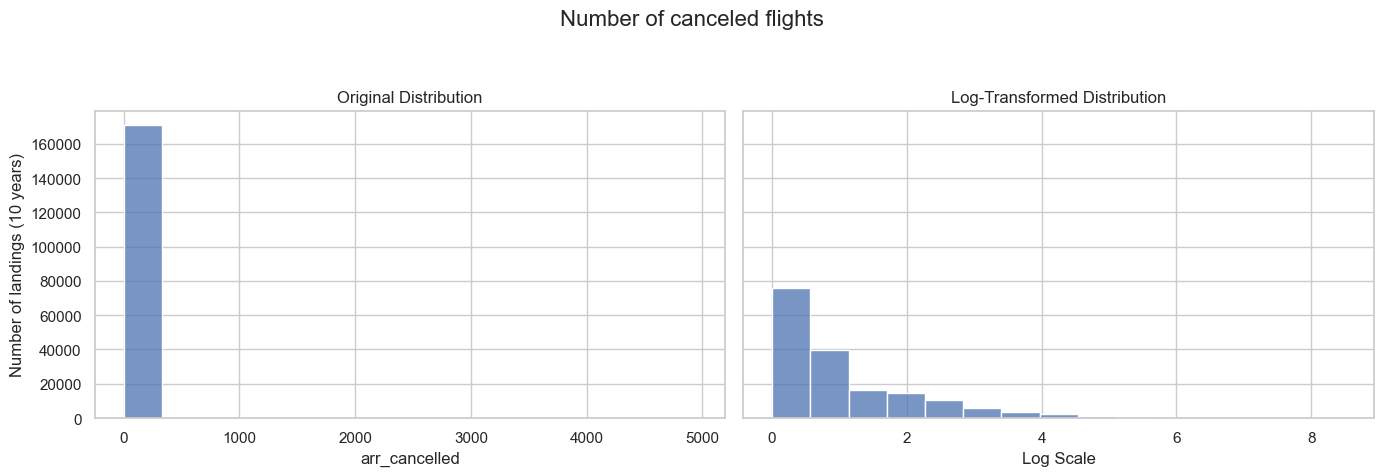

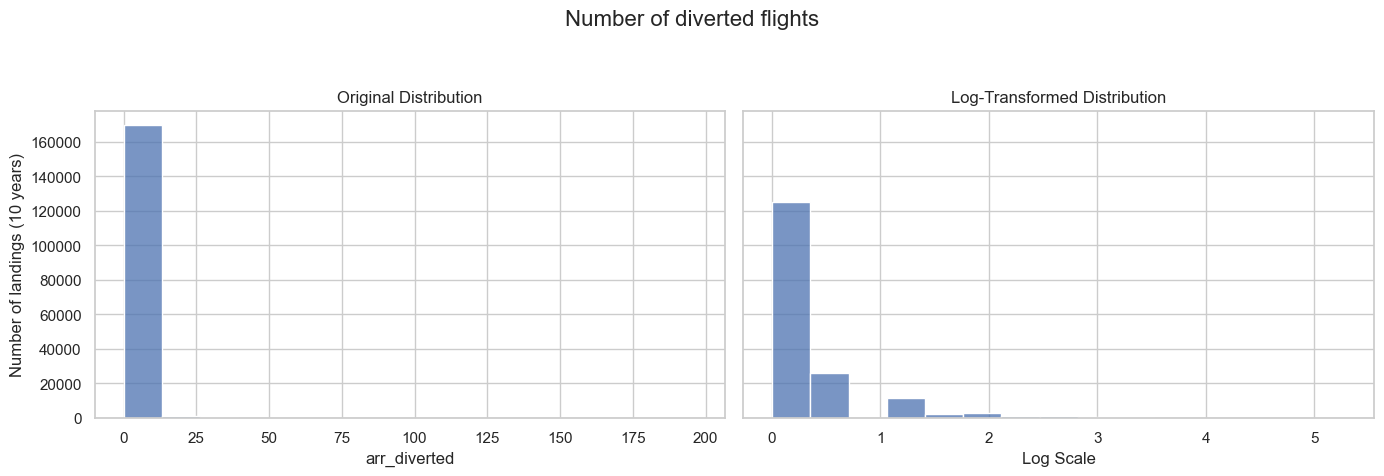

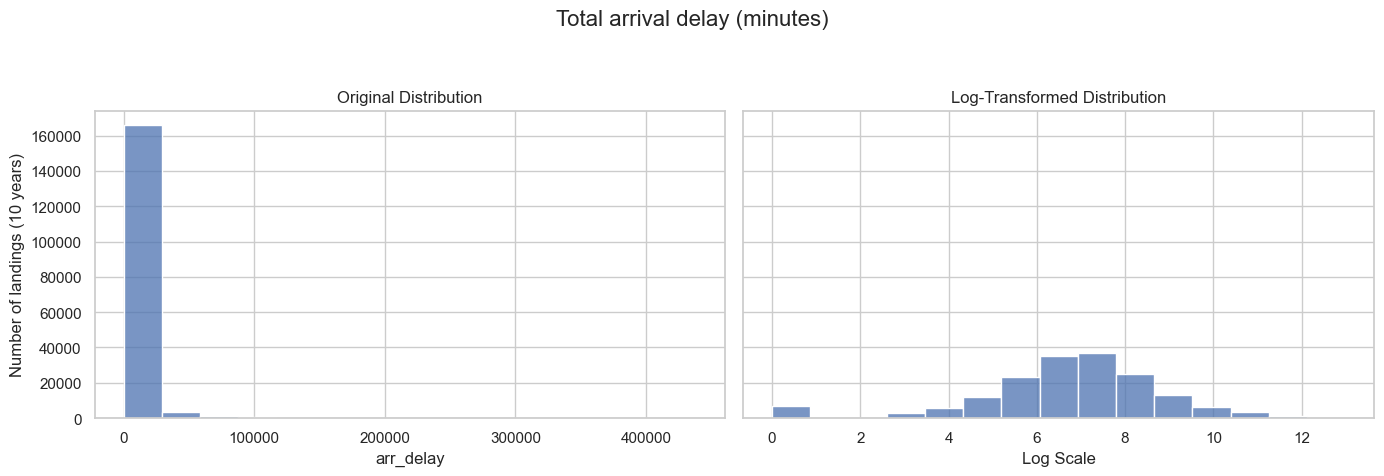

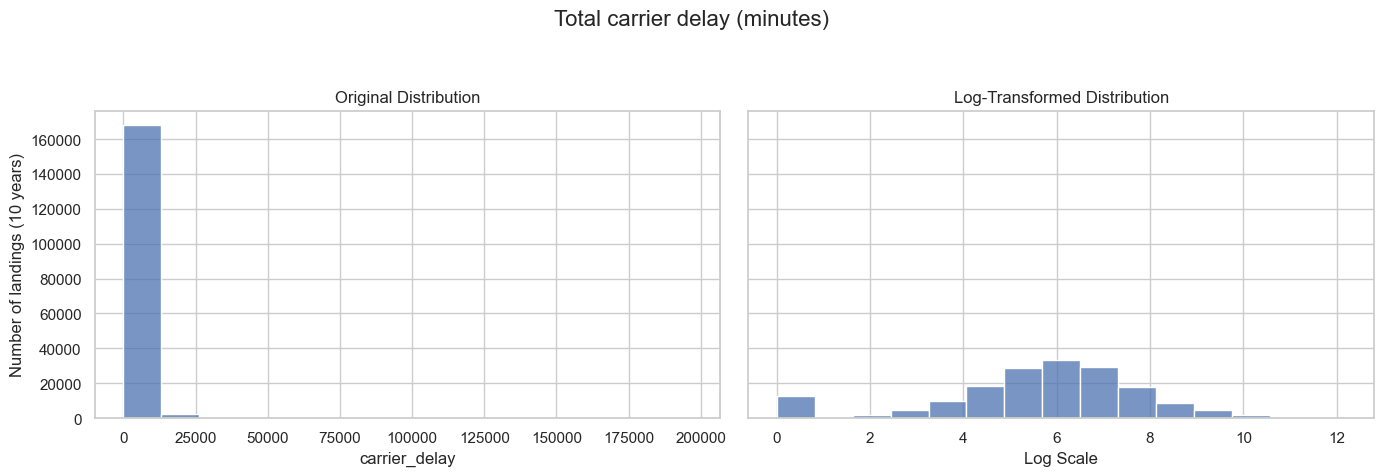

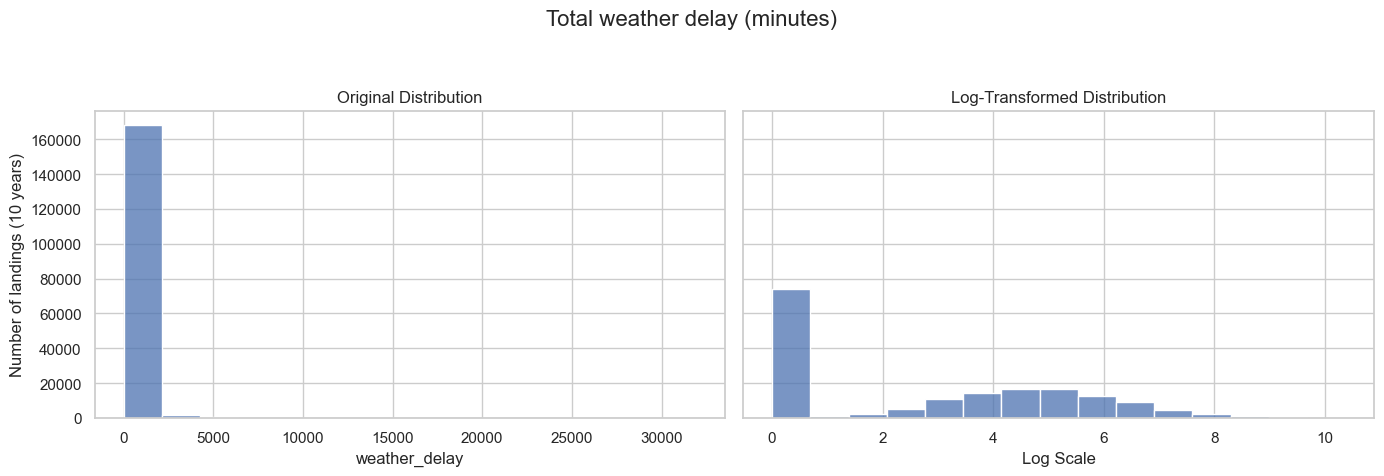

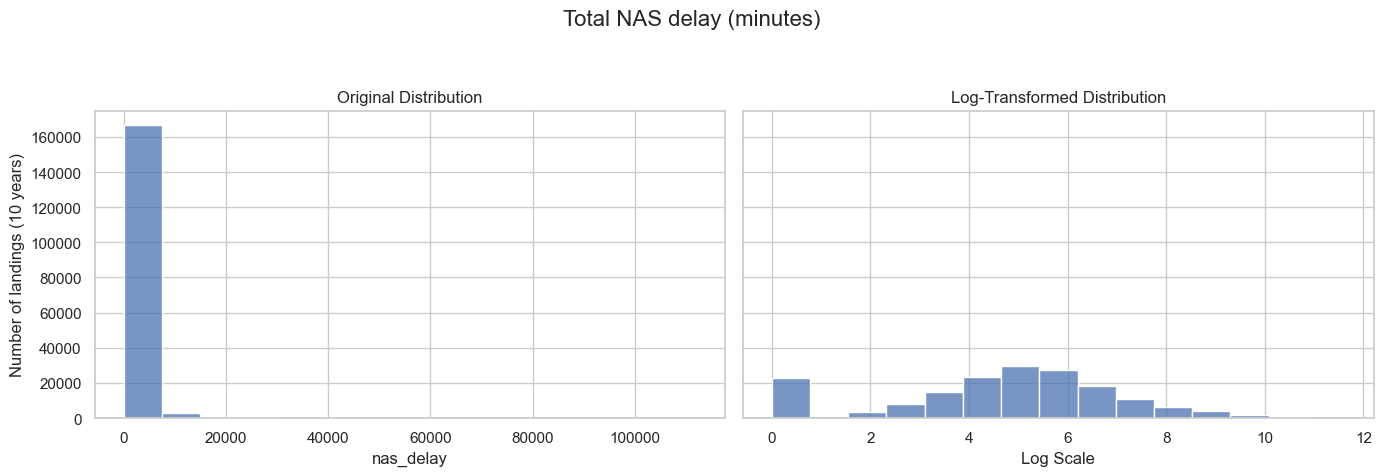

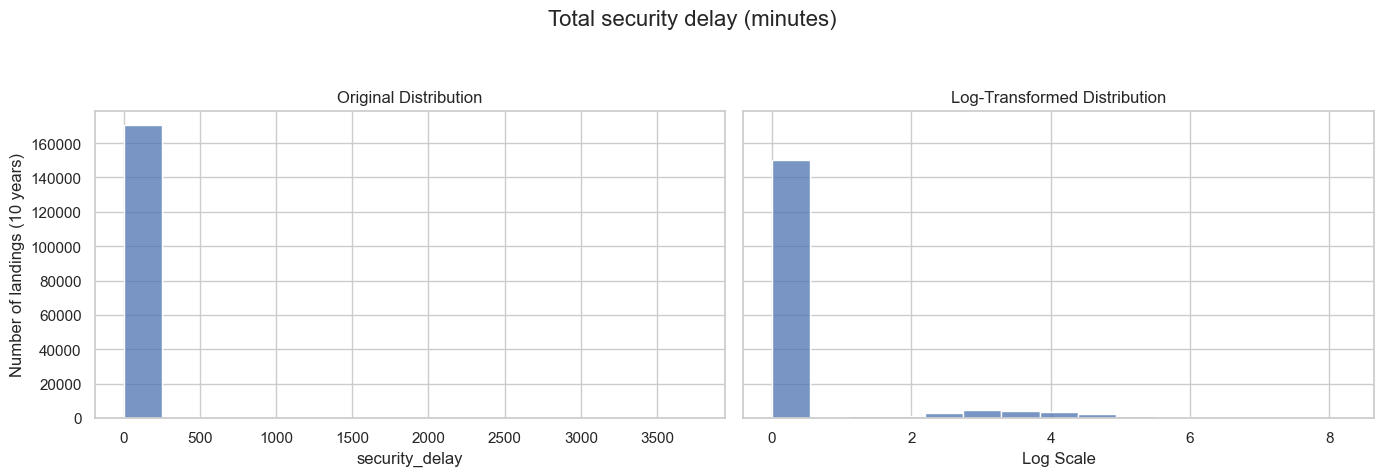

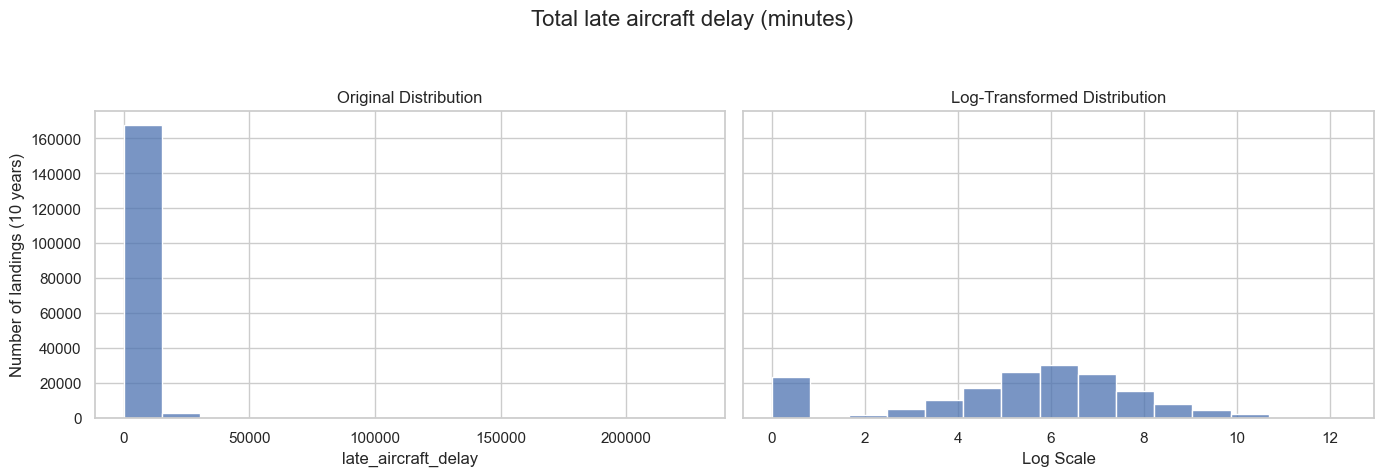

In [11]:
df_num_fet = air_delays_df.select_dtypes(include=["float"]).columns.tolist()
df_num_fet.pop() # remove delay_rate

flight_stats_legend = {
    'arr_flights': 'Number of arriving flights',
    'arr_cancelled': 'Number of canceled flights',
    'arr_diverted': 'Number of diverted flights',
    'arr_del15': 'Number of delayed flights (≥15 min)',
    'carrier_ct': 'Number of carrier-caused delays',
    'weather_ct': 'Number of weather-caused delays',
    'nas_ct': 'Number of NAS-caused delays',
    'security_ct': 'Number of security-caused delays',
    'late_aircraft_ct': 'Number of late aircraft-caused delays',
    'arr_delay': 'Total arrival delay (minutes)',
    'carrier_delay': 'Total carrier delay (minutes)',
    'weather_delay': 'Total weather delay (minutes)',
    'nas_delay': 'Total NAS delay (minutes)',
    'security_delay': 'Total security delay (minutes)',
    'late_aircraft_delay': 'Total late aircraft delay (minutes)'
}

for col in df_num_fet:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    fig.suptitle(flight_stats_legend[col], fontsize=16, y=0.98)

    sns.histplot(ax=axs[0], data=air_delays_df[col], kde=False, bins=15)
    axs[0].set_title("Original Distribution") 
    axs[0].set_ylabel("Number of landings (10 years)")
    axs[0].grid(True)

    sns.histplot(ax=axs[1], data=np.log1p(air_delays_df[col]), kde=False, bins=15)
    axs[1].set_title("Log-Transformed Distribution") 
    axs[1].set_xlabel(f"Log Scale") 
    axs[1].grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

We compared the original distributions against Log-Transformed distributions (`np.log1p`)

**Observations:**
* **Zero-Inflation (Sparsity):**
    Almost all features exhibit a massive spike at 0. This is expected behavior for failure data: the majority of flights do not experience specific delays (e.g., `security_delay`, `weather_delay` is 0 for 99.9% of flights)

* **Heavy Right Skew:**
    The non-zero values form a long tail to the right (extreme delays). Even after Log-transformation, the distributions do not become perfectly Gaussian (Normal). They remain bimodal (a peak at 0 and a "hump" for delayed flights).

**Conclusion:**
Standard linear models may struggle with this sparsity. **Tree-based models** (Gradient Boosting, Random Forest) are preferred as they are robust to non-normal distributions and zero-inflation.

### 3.3 Key Categorical Features

**Objective:**
Examine the categorical features to identify the types of delays affecting different airport categories (small, medium, large, hub) and carriers

We classify airports into percentile groups using the `arr_flights` column, which reflects how many flights an airport receives on average per month over the last 10 years

In [12]:
avg_flights_by_airport = air_delays_df.copy()
avg_flights_by_airport = avg_flights_by_airport.groupby("airport", observed=False)["arr_flights"].mean().reset_index()

avg_flights_by_airport["arr_flights"].describe(percentiles=[0.2, 0.4, 0.6, 0.8])

count     391.000000
mean      185.623205
std       310.633187
min         1.000000
20%        54.250000
40%        70.949710
50%        80.671551
60%        95.212766
80%       177.557042
max      2355.933775
Name: arr_flights, dtype: float64

In [13]:
categories = ["small", "medium", "large", "hub"]
bins = [0, 80, 200, 800, float('inf')]
avg_flights_by_airport["category"] = pd.cut(avg_flights_by_airport["arr_flights"], bins=bins, labels=categories)

air_delays_labeled = air_delays_df.copy()
air_delays_labeled["category"] = air_delays_labeled["airport"].map(avg_flights_by_airport.set_index("airport")["category"])

The thresholds were selected according to the empirical distribution of the dataset to reflect real differences in airport scale:

- Small: < 80 arrivals/month
- Medium: 80-200 arrivals/month
- Large: 200-800 arrivals/month
- Hub: > 800 arrivals/month

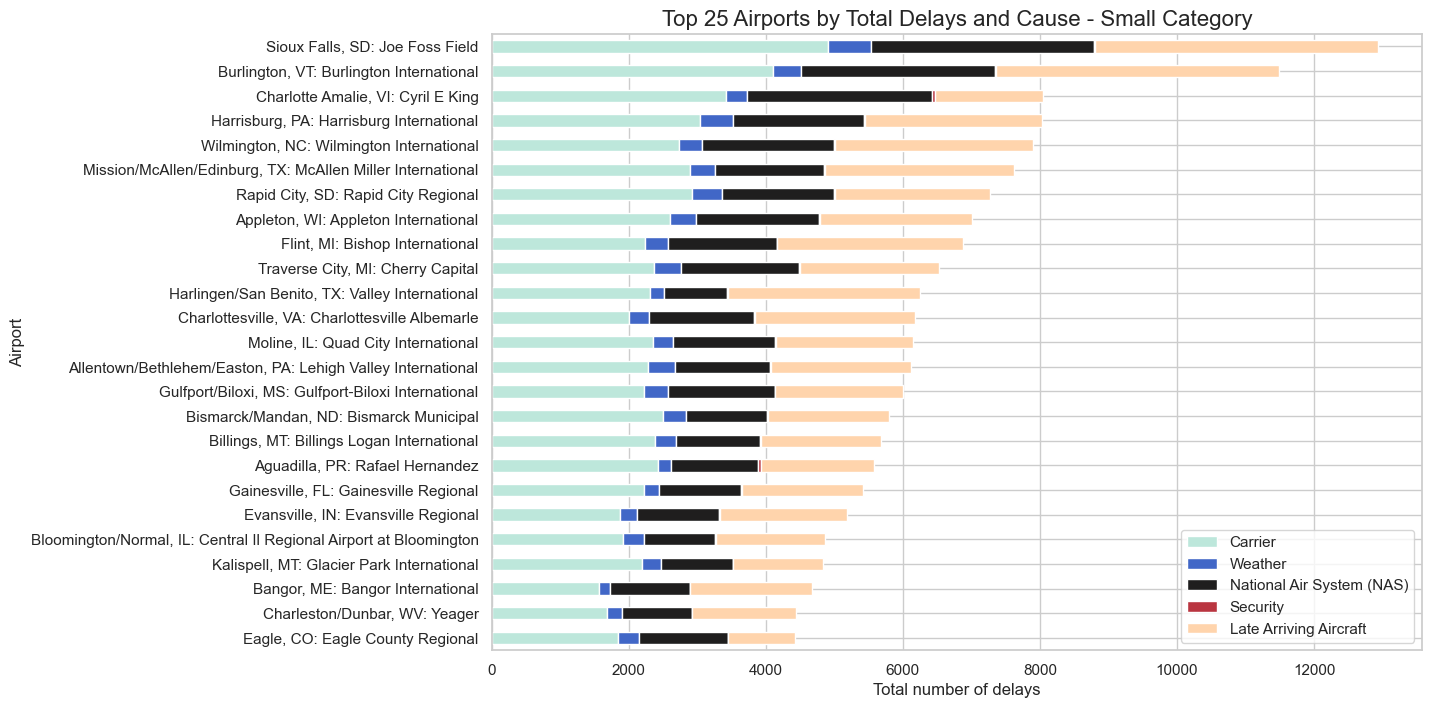

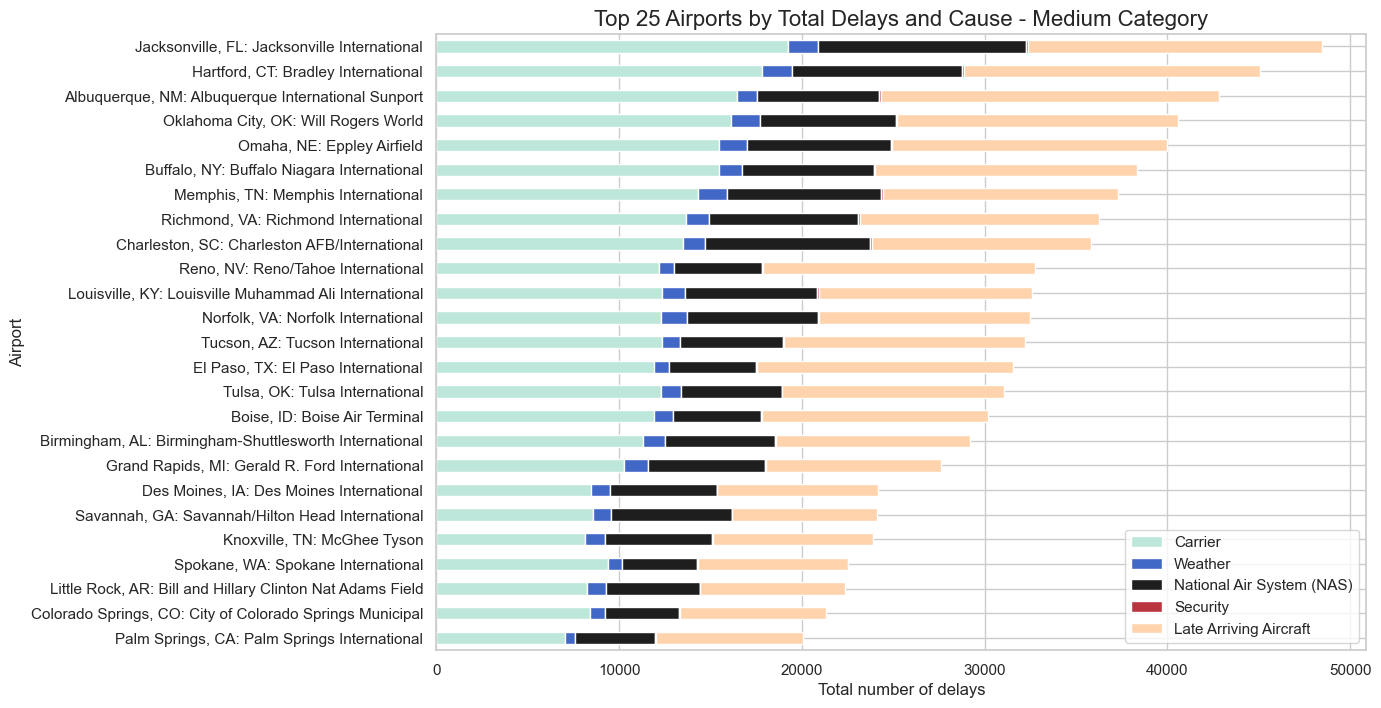

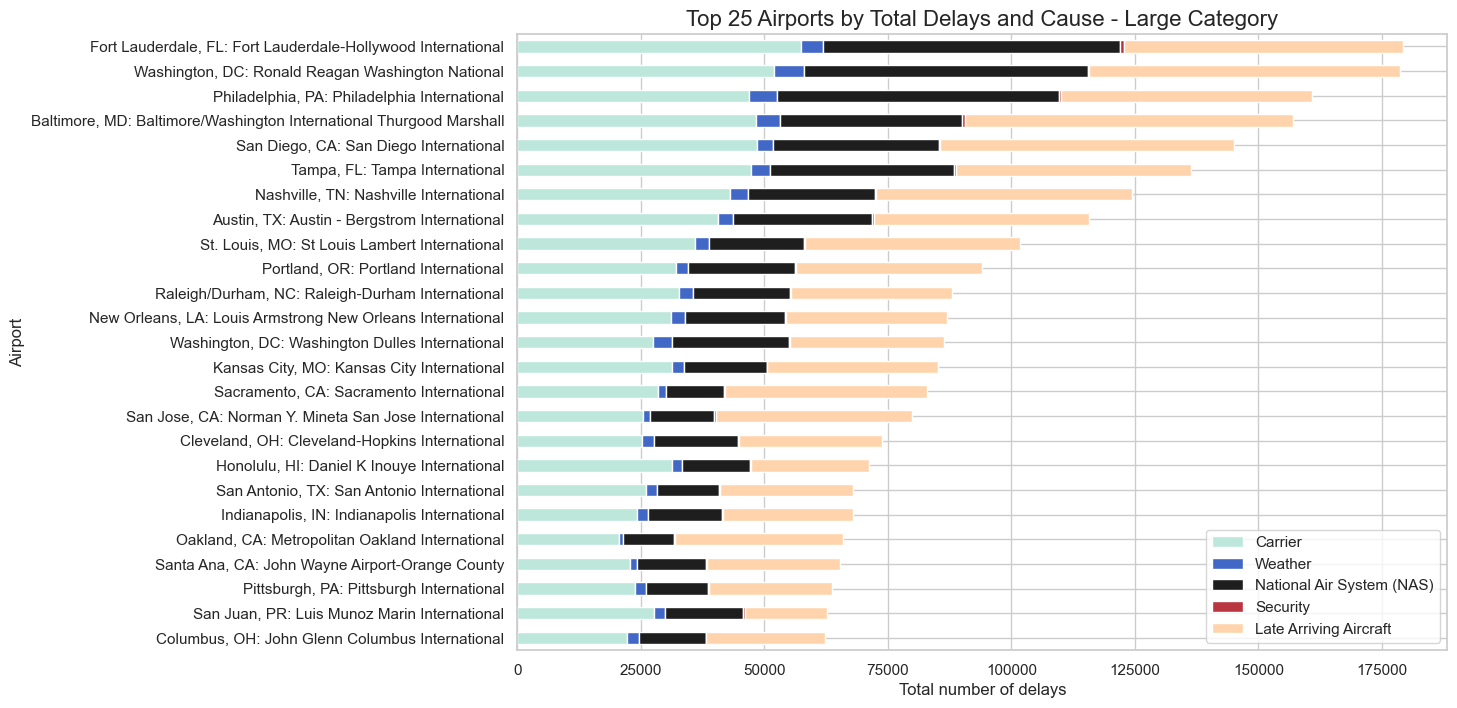

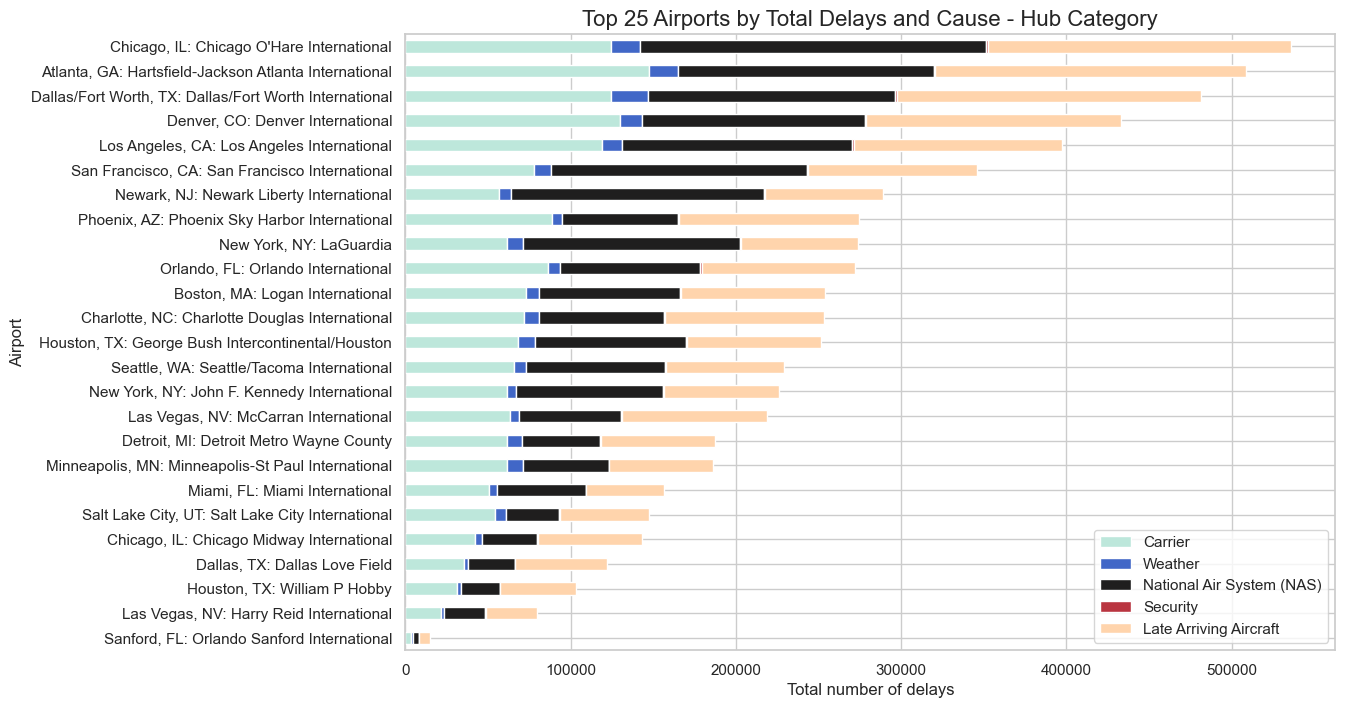

In [14]:
delay_types = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
delay_type_labels = {
    'carrier_ct': 'Carrier',
    'weather_ct': 'Weather',
    'nas_ct': 'National Air System (NAS)',
    'security_ct': 'Security',
    'late_aircraft_ct': 'Late Arriving Aircraft'
}
airport_delays_summary = air_delays_labeled.groupby(["airport_name", "category"], observed=False)[delay_types].sum().reset_index()



for cat in categories:
    df_cat = airport_delays_summary[airport_delays_summary["category"] == cat].copy()

    df_cat["total"] = df_cat[delay_types].sum(axis=1)
    df_cat = df_cat.sort_values(by="total", ascending=True).drop(columns="total")

    top_airports = df_cat.tail(25).copy()
    top_airports.rename(columns=delay_type_labels, inplace=True)
    top_airports.plot(x="airport_name", kind="barh", stacked=True, figsize=(12, 8), colormap="icefire")
    plt.title(f"Top 25 Airports by Total Delays and Cause - {cat.capitalize()} Сategory", fontsize=16)
    plt.xlabel("Total number of delays", fontsize=12)
    plt.ylabel("Airport", fontsize=12)

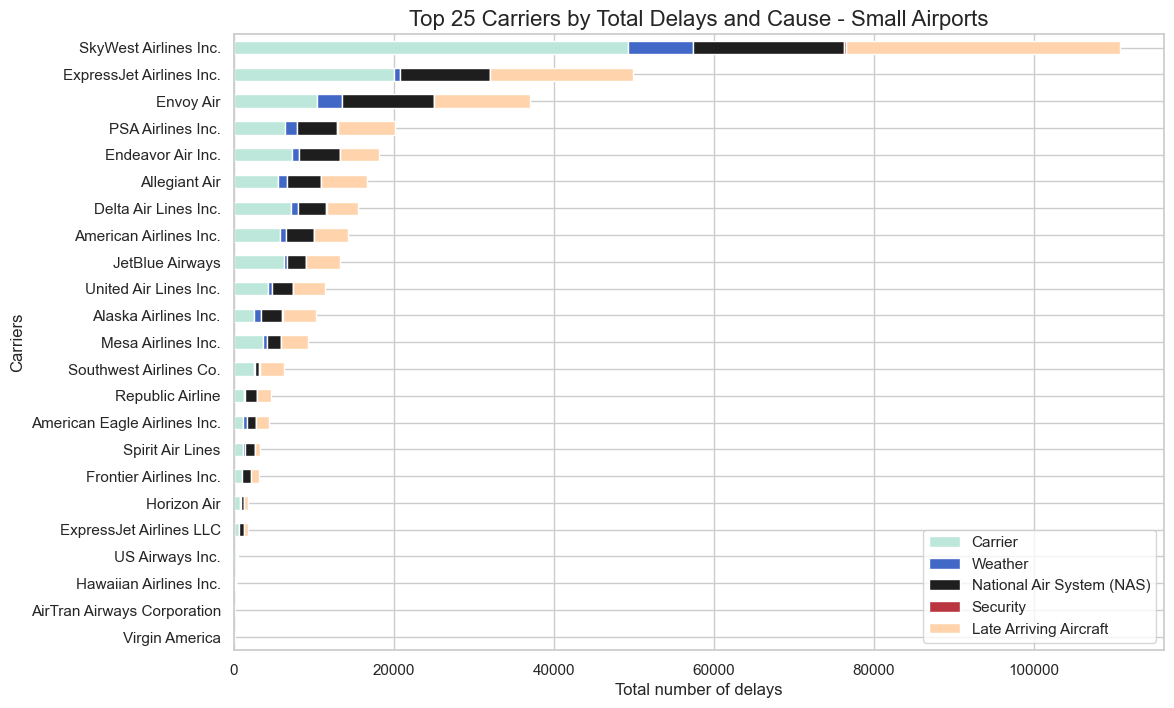

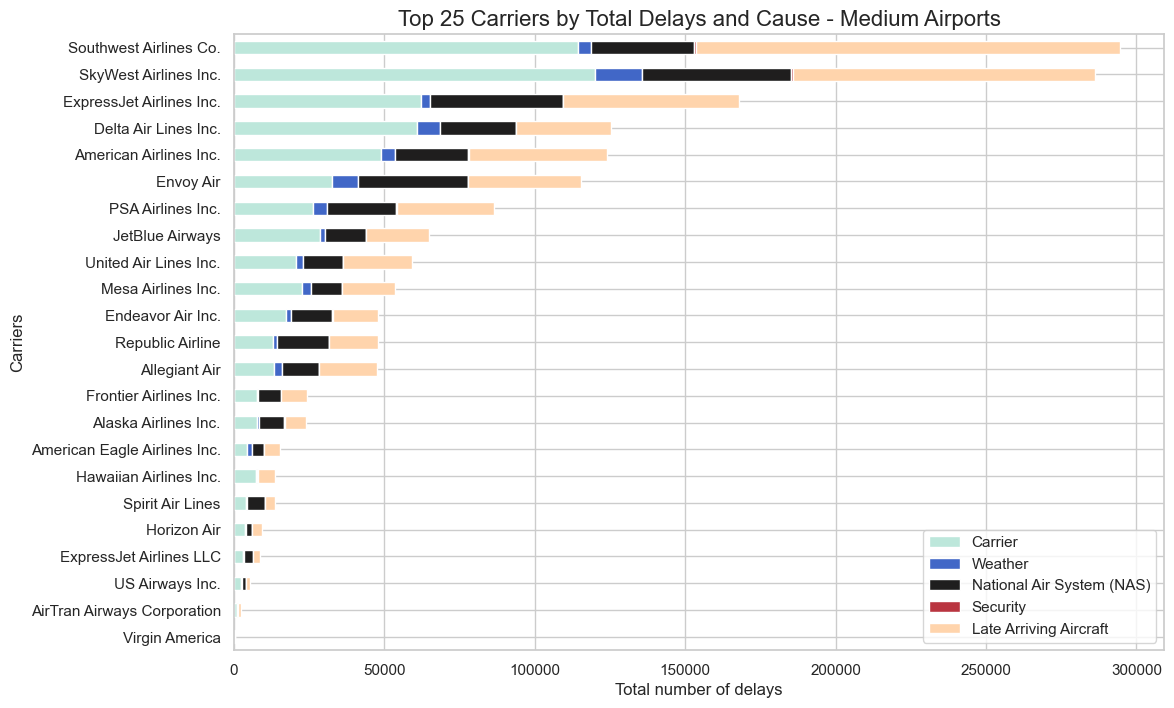

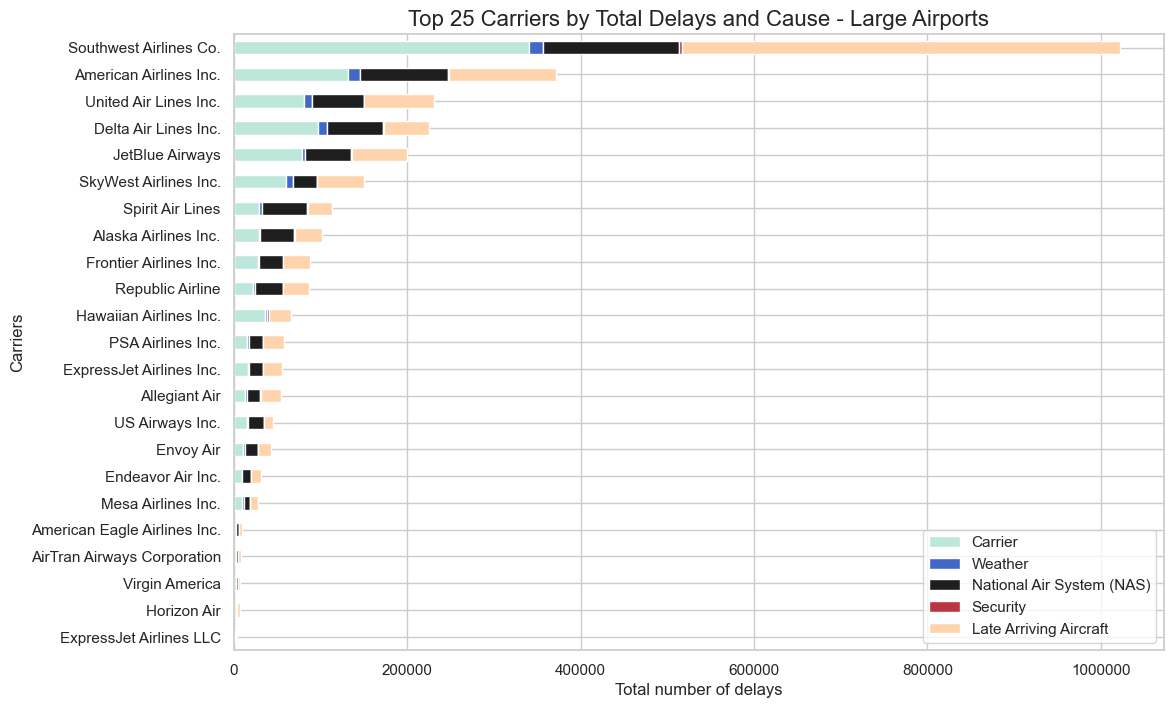

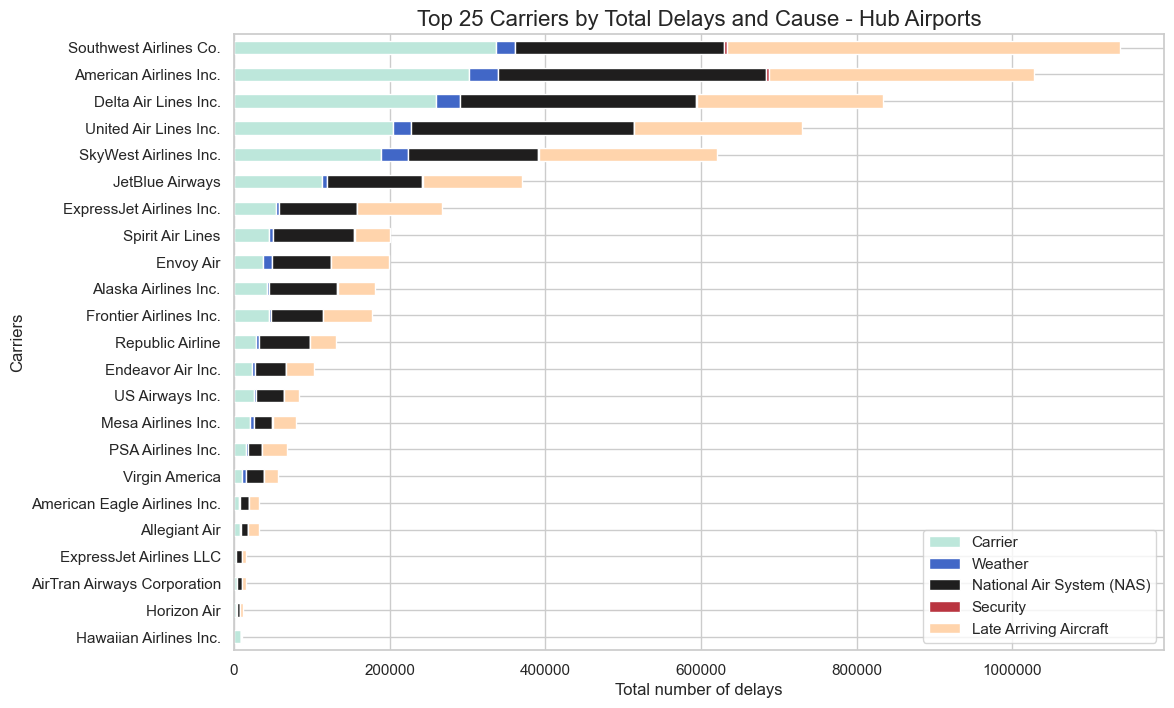

In [15]:
carrier_in_category = air_delays_labeled.groupby(["category", "carrier_name"], observed=False)[delay_types].sum().reset_index()

for cat in categories:
    df_cat = carrier_in_category[carrier_in_category["category"] == cat].copy()

    df_cat["total"] = df_cat[delay_types].sum(axis=1)
    df_cat = df_cat.sort_values(by="total", ascending=True).drop(columns="total")

    top_airports = df_cat.tail(25).copy()
    top_airports.rename(columns=delay_type_labels, inplace=True)
    top_airports.plot(x="carrier_name", kind="barh", stacked=True, figsize=(12, 8), colormap="icefire")
    plt.title(f"Top 25 Carriers by Total Delays and Cause - {cat.capitalize()} Airports", fontsize=16)
    plt.xlabel("Total number of delays", fontsize=12)
    plt.ylabel("Carriers", fontsize=12)
    plt.ticklabel_format(style='plain', axis='x')

**Observations:**
* **The most common reasons for delays:**
    Consistency across categories: The distribution of delay causes remains consistent across different airport categories and carriers. The predominant factors are invariably `carrier_ct`, `nas_ct`, and `late_aircraft_ct`

**Conclusion:**
Variables such as `weather_ct` and `security_ct` represent rare events (high sparsity). Consequently, they likely possess limited predictive power for the general model and are candidates for removal to reduce noise

### 3.4 Bivariate Analysis (Feature vs Target)

**Objective:**

Analyze the impact of the features on the target (`delay_rate`)

#### Correlation Matrices (Pearson & Spearman)

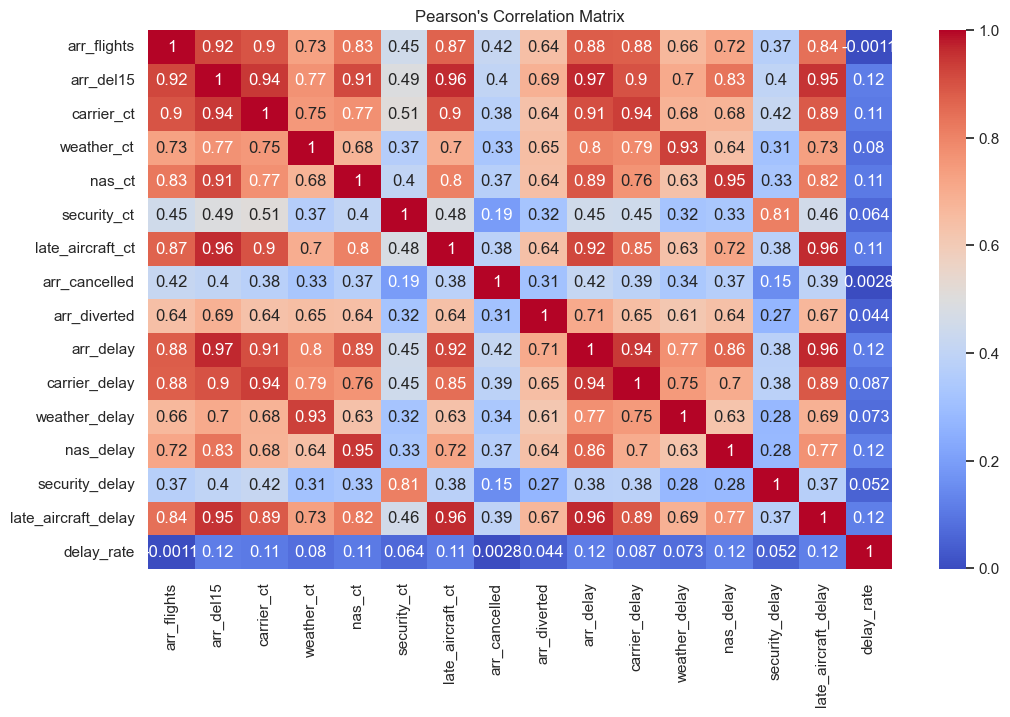

In [16]:
df_num_fet = air_delays_df.select_dtypes(include=["float"]).columns.tolist()

plt.figure(figsize=(12, 7))
sns.heatmap(air_delays_df[df_num_fet].corr(), annot=True, cmap="coolwarm")
plt.title("Pearson's Correlation Matrix")
plt.show()

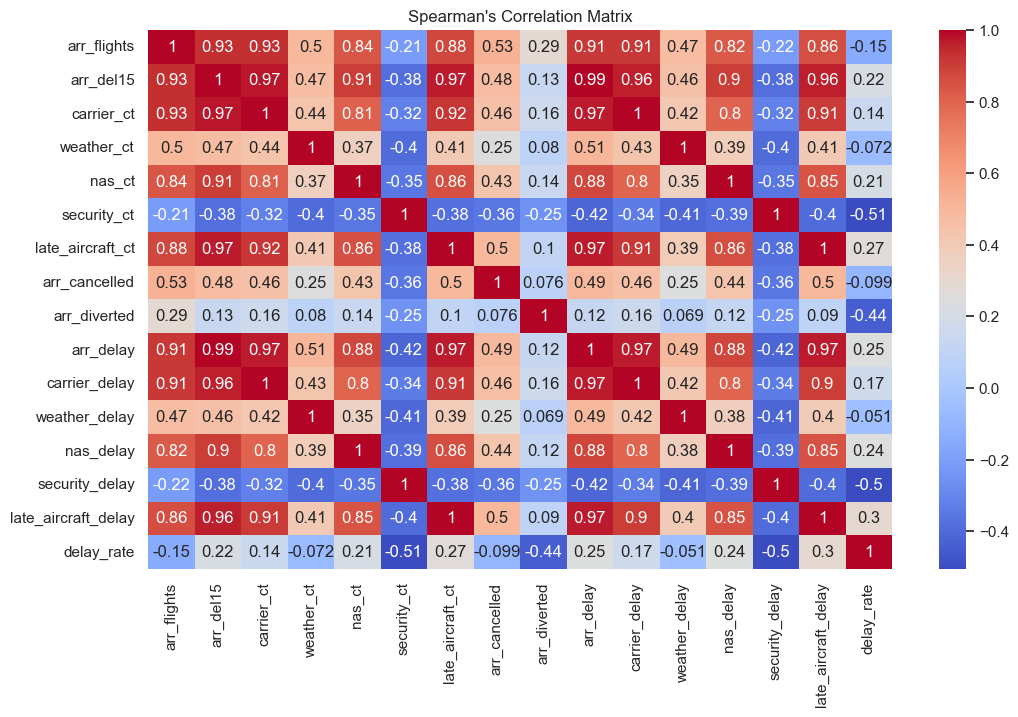

In [17]:
spearman_corr = air_delays_df[df_num_fet].corr(method="spearman")

plt.figure(figsize=(12, 7))
sns.heatmap(spearman_corr.corr(), annot=True, cmap="coolwarm")
plt.title("Spearman's Correlation Matrix")
plt.show()

* **Linearity:** No significant linear correlation with `delay_rate` (Pearson ≈ 0)
* **Monotonicity:** Moderate signals in Spearman correlation (`security_ct`: -0.51, `arr_diverted`: -0.44)
* **Multicollinearity:** Extreme collinearity exists among raw count features (`arr_flights`, `carrier_ct`), which is problematic for linear models but manageable for Boosting

#### Seasonality & "The Funnel Effect"

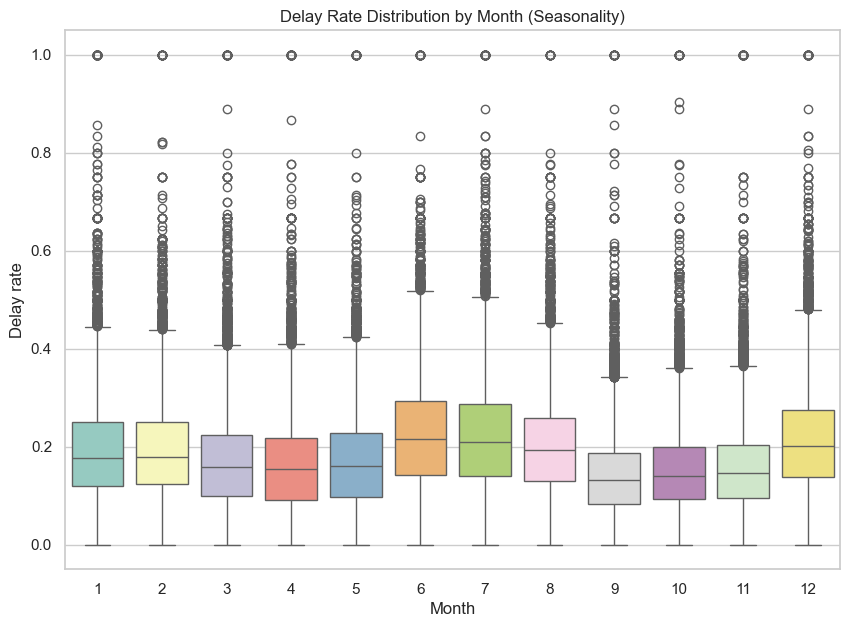

In [18]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="month", y="delay_rate", data=air_delays_df, palette="Set3", hue="month", legend=False)
plt.title("Delay Rate Distribution by Month (Seasonality)")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Delay rate", fontsize=12)
plt.show()

The boxplot exhibits clear seasonal patterns. We observe peaks in both median delay and variance during the summer months (June–August) and December. Conversely, the autumn period (September–November) shows the most stable performance with the lowest median delay rates

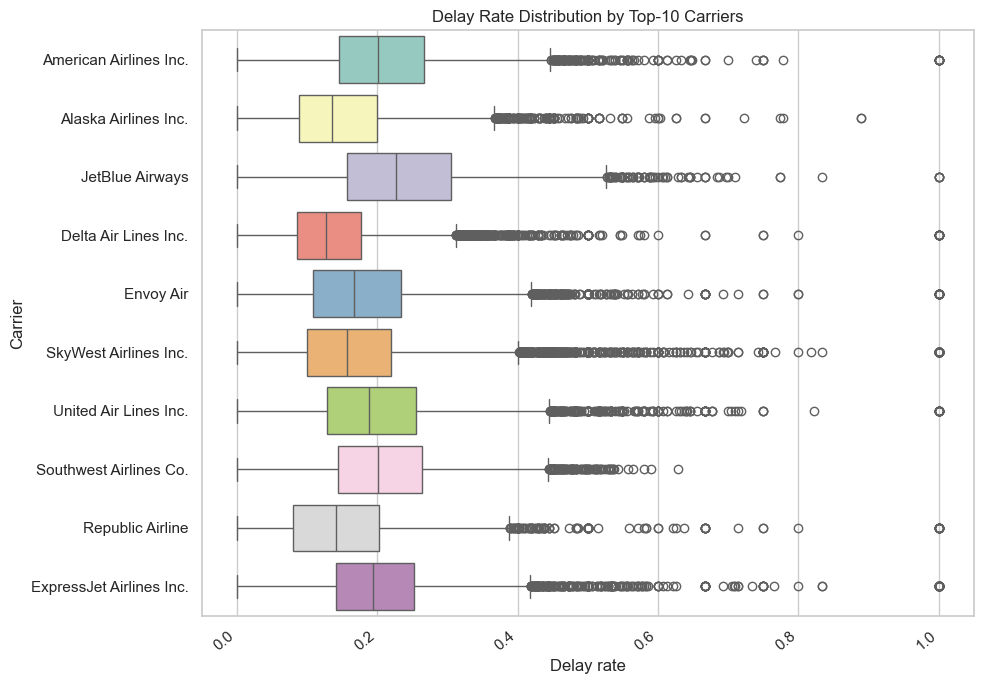

In [19]:
top_10_carriers = air_delays_df.groupby("carrier_name")["arr_flights"].sum().nlargest(10).index
df_top_10_carriers = air_delays_df[air_delays_df["carrier_name"].isin(top_10_carriers)]

plt.figure(figsize=(10, 7))
sns.boxplot(x="delay_rate", y="carrier_name", data=df_top_10_carriers, palette="Set3", hue="carrier_name", legend=False)
plt.title("Delay Rate Distribution by Top-10 Carriers")
plt.xlabel("Delay rate", fontsize=12)
plt.ylabel("Carrier", fontsize=12)
plt.xticks(rotation=40, ha="right")
plt.tight_layout()
plt.show()

There is significant heterogeneity across carriers. Some airlines (e.g., JetBlue) show higher medians and wider Interquartile Ranges (IQR), indicating instability. Others (e.g., Delta) exhibit flatter distributions with lower medians, suggesting more consistent on-time performance

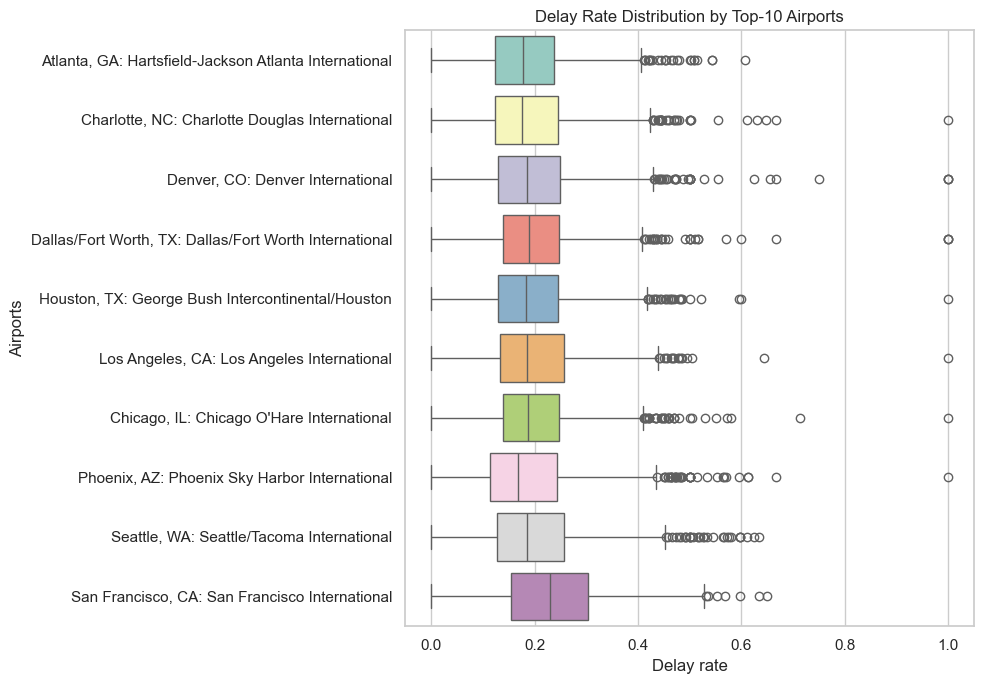

In [20]:
top_10_airports = air_delays_df.groupby("airport_name")["arr_flights"].sum().nlargest(10).index
df_top_10_airports = air_delays_df[air_delays_df["airport_name"].isin(top_10_airports)]

plt.figure(figsize=(10, 7))
sns.boxplot(x="delay_rate", y="airport_name", data=df_top_10_airports, palette="Set3", hue="airport_name", legend=False)
plt.title("Delay Rate Distribution by Top-10 Airports")
plt.xlabel("Delay rate", fontsize=12)
plt.ylabel("Airports", fontsize=12)
plt.tight_layout()
plt.show()

The plot highlights significant differences in reliability among major hubs. Airports like Phoenix and Atlanta demonstrate high stability. In contrast, San Francisco exhibits a wider spread and a higher median, indicating greater volatility and susceptibility to delays

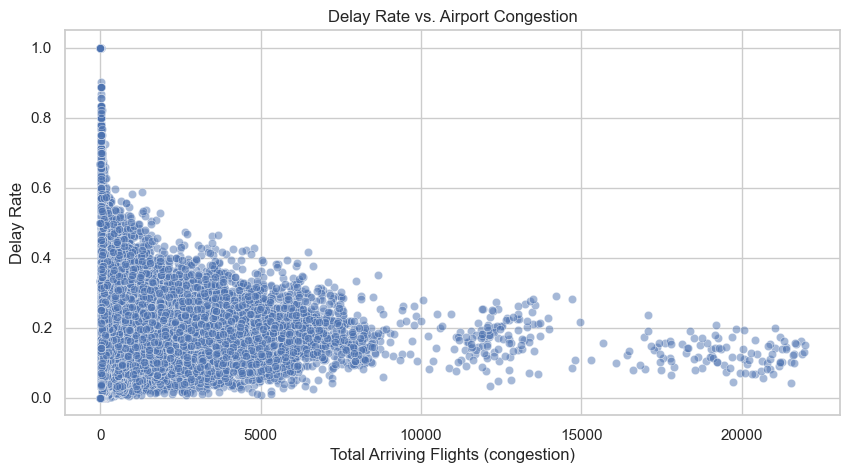

In [21]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=air_delays_df, x="arr_flights", y="delay_rate", alpha=0.5)
plt.title("Delay Rate vs. Airport Congestion")
plt.xlabel("Total Arriving Flights (congestion)")
plt.ylabel("Delay Rate")
plt.show()

The funnel shape demonstrates that higher traffic volume correlates with lower variance, confirming that larger airports operate with greater statistical stability compared to smaller ones

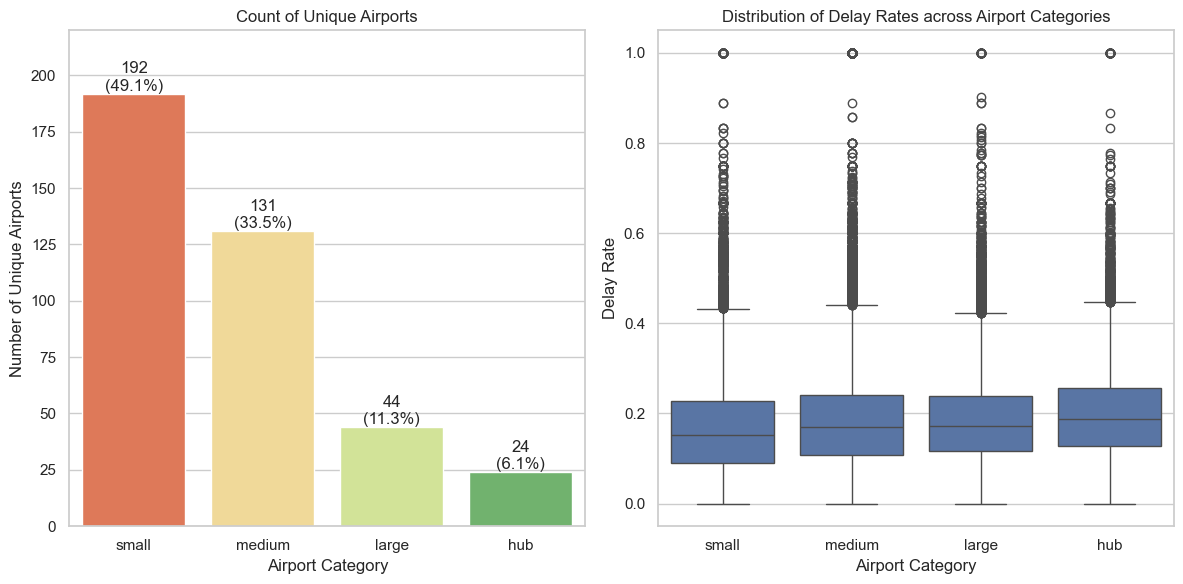

mean       std  max
category                         
small     0.170154  0.119729  1.0
medium    0.182894  0.111891  1.0
large     0.184304  0.102416  1.0
hub       0.198884  0.103998  1.0

In [22]:
avg_flights_by_airport["category"] = pd.cut(avg_flights_by_airport["arr_flights"], bins=bins, labels=categories)

counts = avg_flights_by_airport["category"].value_counts().sort_index()
labeled_df = air_delays_df.copy()
labeled_df["category"] = labeled_df["airport"].map(avg_flights_by_airport.set_index("airport")["category"])

_, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x=counts.index, y=counts.values, ax=axs[0],  palette="RdYlGn", hue=counts.index, legend=False)

axs[0].set_title("Count of Unique Airports")
axs[0].set_xlabel("Airport Category")
axs[0].set_ylabel("Number of Unique Airports")

total_airports = counts.sum()
for p in axs[0].patches:
    percentage = f"{100 * p.get_height() / total_airports:.1f}%"
    axs[0].annotate(f"{int(p.get_height())}\n({percentage})", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="bottom")
axs[0].set_ylim(0, 200 * 1.1)

sns.boxplot(x="category", y="delay_rate", data=labeled_df, ax=axs[1])
axs[1].set_title("Distribution of Delay Rates across Airport Categories")
axs[1].set_xlabel("Airport Category")
axs[1].set_ylabel("Delay Rate")

plt.tight_layout()
plt.show()

stability_metrics = labeled_df.groupby("category", observed=False)["delay_rate"].agg(["mean", "std", "max"])
display(stability_metrics)

Remarkably, the median delay rate (~0.18) remains consistent across all categories, from small airfields to major hubs. This indicates that the average probability of a flight being delayed is largely independent of airport size

Airport size does not significantly reduce the average delay rate, but larger airports tend to have slightly more stable performance. The target variable `delay_rate` is heavily influenced by outliers in all categories, confirming the need for robust loss functions (e.g., MAE/Huber) during modeling

**Observations:**
* **Correlation Structure:**
    The target variable delay_rate shows negligible linear correlation (Pearson ≈ 0) with predictors but stronger monotonic signals (Spearman). This confirms that the relationships in the data are predominantly non-linear

* **Seasonality and Carrier Heterogeneity:**
    The data exhibits strong temporal and categorical dependencies. Seasonal peaks in variance and median delays are evident during Summer (June–August) and December, while Autumn is the most stable period. Furthermore, significant heterogeneity exists across carriers: some (e.g., Delta) show consistent performance, while others (e.g., JetBlue) exhibit high instability (wide IQR), making carrier a crucial predictor
* **The "Funnel Effect":**
    A clear inverse relationship exists between traffic volume and variance. While the median delay rate (~0.18) remains remarkably consistent across all airport sizes, volatility decreases as traffic increases. Small airports are prone to extreme variance due to the "small sample size" effect, whereas major hubs (like Atlanta) are statistically more stable, though not immune to systemic outliers (up to 1.0)

**Conclusion:**
* **Model Selection:** Given the lack of linear correlation and the presence of severe multicollinearity among count features, linear models are ill-suited. Gradient Boosting frameworks (XGBoost, CatBoost) are preferable to handle the non-linear dependencies and feature interactions effectively
* **Loss Function:** Since outliers are prevalent in all categories—driven by volatility in small airports and systemic issues in hubs—standard MSE may be too sensitive. Utilizing robust loss functions like MAE or Huber Loss is essential to build a generalized model

### 3.5 Temporal Analysis

**Objective:**

To investigate temporal patterns and seasonality in flight delays

In [23]:
date_df = air_delays_df.copy()

date_df["date"] = pd.to_datetime(dict(year=air_delays_df["year"], month=air_delays_df["month"], day=1))
date_df = date_df.set_index("date")
date_df = date_df.sort_index()

delays_over_time = date_df.groupby("date")["delay_rate"].mean().reset_index()

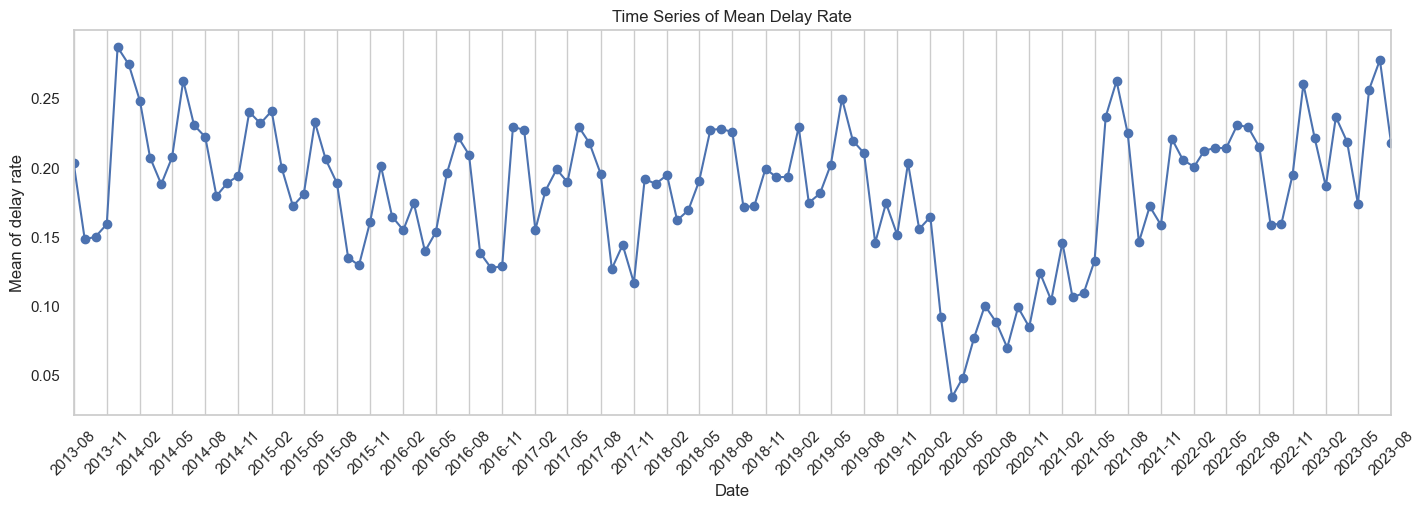

In [24]:
_, ax = plt.subplots(figsize=(17, 5))
ax.plot(delays_over_time["date"], delays_over_time["delay_rate"], marker='o')
ax.set_title("Time Series of Mean Delay Rate")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Mean of delay rate", fontsize=12)
ax.tick_params(axis="x", rotation=45)
ax.set_xlim(dt.datetime(2013, 8, 1), dt.datetime(2023, 8, 1))
ax.grid(axis="y")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

The timeline reveals a clear cyclic pattern with recurring seasonal spikes. A massive drop (anomaly) is observed in early 2020, driven by the COVID-19 pandemic and reduced air traffic. By 2022, the delay rates rebounded, returning to historical highs

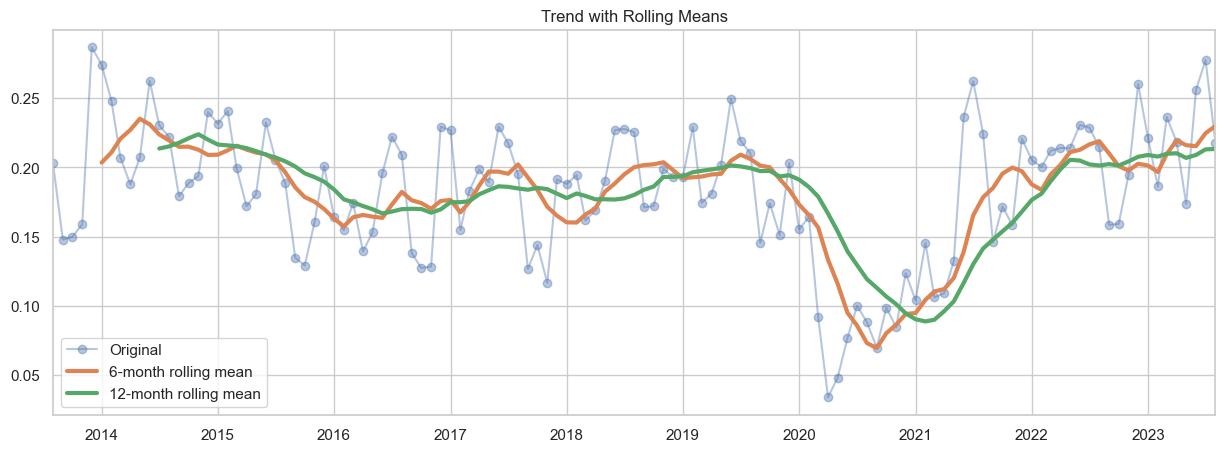

In [25]:
delays_over_time["rolling_6"] = delays_over_time["delay_rate"].rolling(window=6).mean()
delays_over_time["rolling_12"] = delays_over_time["delay_rate"].rolling(window=12).mean()

plt.figure(figsize=(15, 5))
plt.plot(delays_over_time["date"], delays_over_time["delay_rate"], marker='o', alpha=0.4, label="Original")
plt.plot(delays_over_time["date"], delays_over_time["rolling_6"], linewidth=3, label="6-month rolling mean")
plt.plot(delays_over_time["date"], delays_over_time["rolling_12"], linewidth=3, label="12-month rolling mean")
plt.xlim(dt.datetime(2013, 8, 1), dt.datetime(2023, 8, 1))
plt.title("Trend with Rolling Means")
plt.legend()
plt.show()

By applying a 12-month rolling mean, we successfully smoothed out the short-term seasonal fluctuations. This reveals the true long-term trajectory of the dataset. The visualization confirms that the steep decline in 2020 was a distinct regime change rather than a seasonal anomaly

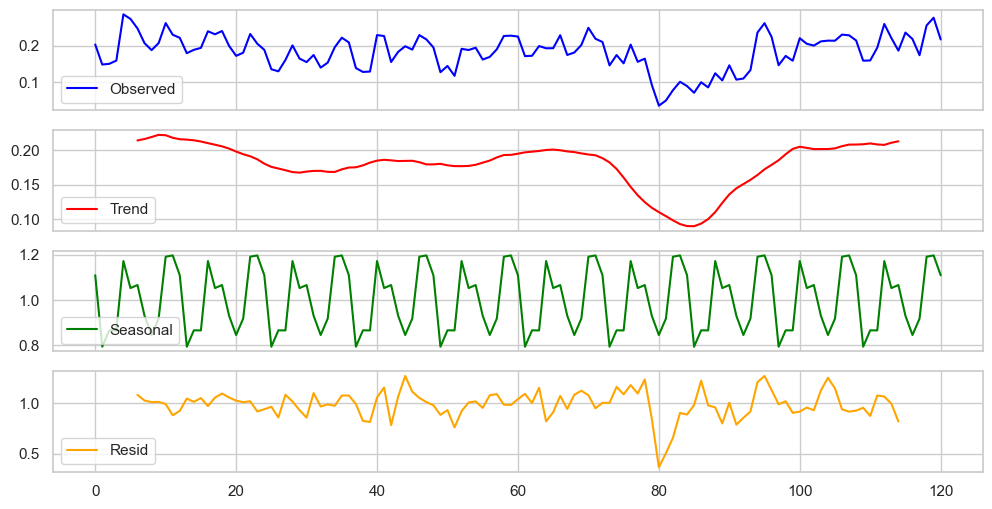

In [26]:
delay_decomp = seasonal_decompose(delays_over_time["delay_rate"], model="multiplicative", period=12)

fig, axs = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

axs[0].plot(delay_decomp.observed, label="Observed", color="blue")
axs[0].legend(loc="lower left")

axs[1].plot(delay_decomp.trend, label="Trend", color="red")
axs[1].legend(loc="lower left")

axs[2].plot(delay_decomp.seasonal, label="Seasonal", color="green")
axs[2].legend(loc="lower left")

axs[3].plot(delay_decomp.resid, label="Resid", color="orange")
axs[3].legend(loc="lower left")

plt.legend()
plt.show()

We performed a seasonal decomposition to isolate the underlying components of the `delay_rate` time series:

1. The raw data, clearly showing the variance and the structural break in 2020

2. This component smooths out the noise, revealing the long-term trajectory. It highlights the severity of the pandemic-induced drop and the subsequent recovery phase starting in 2021

3. A clear, repeating annual pattern is identified. This confirms that flight delays are inherently cyclical, with consistent peaks in summer and winter, regardless of the year

4. The Residuals plot exposes a significant anomaly around 2020, where the model's error variance spikes. This confirms that the pandemic period introduced irregular noise that disrupted the standard patterns, effectively acting as a massive outlier in the timeline

**Observations:**
* **Structural Break and Recovery:**
     The 12-month rolling mean effectively filters out seasonal noise, revealing a distinct structural break in early 2020 due to the COVID-19 pandemic

* **Decomposition & Residuals:**
    The seasonal decomposition confirms that delays are inherently cyclical. However, the Resid plot highlights extreme unexplained variance during the 2020 period. This indicates that the pandemic caused an exogenous shock that disrupts standard seasonal patterns, effectively acting as a massive outlier sequence

**Conclusion:** Given the strong cyclical signal, the inclusion of temporal features is mandatory. Specifically, Cyclical Encoding (Sine/Cosine features for months) or lag features (e.g., lag_12) should be generated to help the model capture these recurring patterns. The high residuals in 2020 suggest that training on this specific period might introduce noise, adding a binary feature (is_covid_anomaly) will be crucial for the model to distinguish between normal seasonal dips and structural anomalies

### 3.6 Geospatial Analysis of Delay Causes

**Objective:**

To visualize the geographic distribution of flight delays and identify if specific regions or hubs are prone to specific types of delays

In [27]:
airport_coordinates = pd.read_csv(Path("data") / "airports.csv")
airport_coordinates.rename(columns={"IATA": "airport"}, inplace=True)
filtered_air_delays = air_delays_df[air_delays_df["airport"].isin(airport_coordinates["airport"])].copy()

filtered_air_delays["latitude"] = filtered_air_delays["airport"].map(airport_coordinates.set_index("airport")["LATITUDE"])
filtered_air_delays["longitude"] = filtered_air_delays["airport"].map(airport_coordinates.set_index("airport")["LONGITUDE"])

In [28]:
unique_airports_1 = air_delays_df["airport"].unique()
unique_airports_2 = airport_coordinates["airport"].unique()

count_missing = (~np.isin(unique_airports_1, unique_airports_2)).sum()
print(f"Coordinates not found for {count_missing} out of {len(unique_airports_1)} airports")

Coordinates not found for 57 out of 391 airports


The auxiliary dataset lacked coordinates for 57 airports. These locations were omitted from the map. Assuming they represent a negligible portion of total flights, we proceeded with the remaining major airports

In [29]:
aggregation_rules = {
    'latitude': 'first',     
    'longitude': 'first',  
    'airport_name': 'first',   
    'arr_flights': 'sum',     
    'arr_del15': 'sum',       
    'carrier_ct': 'sum',      
    'weather_ct': 'sum',
    'nas_ct': 'sum',
    'security_ct': 'sum',
    'late_aircraft_ct': 'sum'
}


airport_summary = filtered_air_delays.groupby("airport").agg(aggregation_rules).reset_index()
airport_summary["dominant_cause"] = airport_summary[delay_types].idxmax(axis=1)

In [30]:
fig = px.scatter_geo(
    airport_summary,
    lat="latitude",
    lon="longitude",           
    size="arr_flights",     
    color="dominant_cause",    
    projection="albers usa",  
    hover_name="airport_name",
    title="Airports on the Map"
)

fig.update_geos(
    scope="usa",        
    showland=True,
    landcolor="lightgray",
    showlakes=True,
    lakecolor="lightblue"
)

fig.show()

The map highlights major hubs (indicated by larger bubbles). As observed in the previous analysis, the dominant causes of delay (`carrier_ct`, `late_aircraft_ct`, `nas_ct`) remain consistent across all locations, irrespective of airport size

---

## 4. Feature Engineering

### 4.1 Structural & Temporal Preprocessing

In [31]:
air_delays_df_fe = air_delays_df.copy()
air_delays_df_fe = air_delays_df_fe.drop(columns=["carrier_name", "airport_name"], axis=1)

We remove the full names of airports and carriers, since we have their IATA codes (`airport`, `carrier`)

In [32]:
condition = (
    ((air_delays_df_fe["year"] == 2020) & (air_delays_df_fe["month"] >= 3)) |
    ((air_delays_df_fe["year"] == 2021) & (air_delays_df_fe["month"] <= 11))
)

air_delays_df_fe["is_covid_anomaly"] = np.where(condition, 1, 0)

As we found out earlier, the dataset covers the pandemic period, which represents a massive exogenous shock to the aviation industry. To help the model distinguish between "normal" operations and the pandemic anomaly, we introduce a binary flag `is_covid_anomaly`, which covers the period from March 3, 2020 to November 11, 2021

We transform the Month column into sine and cosine components. This is crucial because time is cyclical, but standard numerical encoding (1 vs 12) implies a large distance

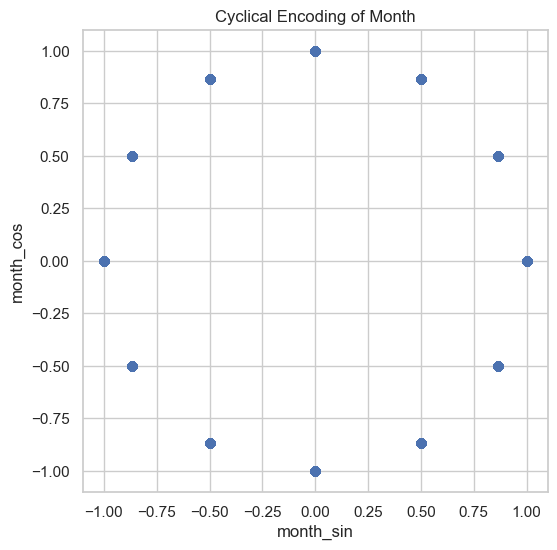

In [33]:
air_delays_df_fe["month_sin"] = np.sin(2 * np.pi * air_delays_df_fe["month"]/12)
air_delays_df_fe["month_cos"] = np.cos(2 * np.pi * air_delays_df_fe["month"]/12)

plt.figure(figsize=(6, 6))
plt.scatter(air_delays_df_fe["month_sin"], air_delays_df_fe["month_cos"])
plt.title("Cyclical Encoding of Month")
plt.xlabel("month_sin")
plt.ylabel("month_cos")
plt.show()

Now the months are placed at meaningful cyclic distances

### 4.2 Historical Feature Generation

In [34]:
lag_strategy = {
    'delay_rate': ['lag1', 'lag12', 'roll12'],
    'late_aircraft_delay': ['lag1', 'lag12', 'roll12'],
    'carrier_delay': ['lag1', 'lag12', 'roll12'],
    'nas_delay': ['lag1', 'lag12', 'roll12'],
    'weather_delay': ['roll12']
}

air_delays_df_fe = air_delays_df_fe.sort_values(by=["carrier", "airport", "year", "month"])

for col, strategies in lag_strategy.items():
    grouped = air_delays_df_fe.groupby(["carrier", "airport"])[col]

    if "lag1" in strategies:
        air_delays_df_fe[f"{col}_lag1"] = grouped.transform(lambda x: x.shift(1))
    if "lag12" in strategies:
        air_delays_df_fe[f"{col}_lag12"] = grouped.transform(lambda x: x.shift(12))
    if "roll12" in strategies:
        air_delays_df_fe[f"{col}_roll12_mean"] = grouped.transform(lambda x: x.shift(1).rolling(window=12).mean())

air_delays_df_fe = air_delays_df_fe.dropna()

We generate historical features based on the nature of each variable to capture trends without data leakage:
* **Target & Main Drivers (`delay_rate`, `late_aircraft`, `carrier`):** We generate Lag-1, Lag-12 (seasonality), and Rolling-12 Mean to capture both immediate inertia and long-term trends
* **Stochastic Factors (`weather`, `nas`):** We generate only Rolling-12 Mean. Since weather is random, last month's specific weather (`Lag-1`) is noise, but the yearly trend (`Rolling`) captures the general climate/traffic conditions
* **Sparse Features (`security`):** Excluded to avoid high dimensionality with zero-variance vectors

### 4.3 Leakage Prevention

In [35]:
air_delays_df_fe_test = air_delays_df_fe.drop(["arr_del15", "carrier_ct", "weather_ct", "nas_ct", "security_ct", "late_aircraft_ct", "arr_delay",
                      "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay", "arr_cancelled", "arr_diverted"], axis=1)
air_delays_df_fe_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141334 entries, 95917 to 1558
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   year                             141334 non-null  int64  
 1   month                            141334 non-null  int64  
 2   carrier                          141334 non-null  object 
 3   airport                          141334 non-null  object 
 4   arr_flights                      141334 non-null  float64
 5   delay_rate                       141334 non-null  float64
 6   is_covid_anomaly                 141334 non-null  int32  
 7   month_sin                        141334 non-null  float64
 8   month_cos                        141334 non-null  float64
 9   delay_rate_lag1                  141334 non-null  float64
 10  delay_rate_lag12                 141334 non-null  float64
 11  delay_rate_roll12_mean           141334 non-null  float64
 12  late_

All raw "current month" columns are dropped (we cannot know `weather_delay` for next month in advance)

**Conclusion:**

We have successfully transformed the raw dataset into a format suitable for supervised machine learning algorithms. The engineered dataset now captures temporal dynamics, seasonality, and structural anomalies while strictly strictly adhering to leakage prevention protocols
* **Temporal Logic:**
    * By converting `Month` into Cyclical Features (Sine/Cosine), we enabled the model to understand the continuity of time (e.g., December is close to January)
    * The introduction of the `is_covid_anomaly` flag allows the model to differentiate between "normal" market behavior and the exogenous shock of the pandemic

* **Historical Context:**
    * We transitioned from point-in-time data to time-series sequences
    * The generated lags (t-1) and seasonal components (t-12) provide the model with immediate context and long-term baselines
    * Rolling Means smooth out stochastic noise (especially for weather), revealing underlying trends
* **Data Integrity & Efficiency":**
    *  All "future-peeking" variables (current month's delays) have been removed. The model relies solely on past information and known schedules (`arr_flights`)
    *  Redundant identifiers (names) and sparse features (`security`) were dropped to reduce dimensionality and computational cost

---

## 5. Model Training Setup

### 5.1 Chronological Train-Test Split

In [36]:
air_delays_df_fe = air_delays_df_fe.sort_values(by=["year", "month"], ascending=True)

y = air_delays_df_fe["delay_rate"]
X = air_delays_df_fe.drop("delay_rate", axis=1)

n_total = len(air_delays_df_fe)

val_start_idx = int(n_total * 0.70)
test_start_idx = int(n_total * 0.85)

X_train = X.iloc[:val_start_idx]
y_train = y.iloc[:val_start_idx]  

X_val = X.iloc[val_start_idx:test_start_idx]
y_val = y.iloc[val_start_idx:test_start_idx] 

X_test = X.iloc[test_start_idx:]
y_test = y.iloc[test_start_idx:]   

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (98933, 35), Val: (21200, 35), Test: (21201, 35)


Since we are dealing with time-series data, random shuffling is strictly prohibited as it would lead to data leakage. We sort the data by year and month and apply a hard chronological cut, the first 70% of the timeline is used for training, and the last 30% is reserved for validation and testing

### 5.2 Preprocessing Pipelines

In [37]:
new_features = [col for col in air_delays_df_fe.columns if "_roll12_mean" in col or "_lag12" in col or "_lag1" in col]

In [38]:
FEATURES_LINEAR = {
    "categorical_te": ['carrier', 'airport'],
    "numeric_scaled": ['year', 'is_covid_anomaly', 'month_sin', 'month_cos'] + new_features,
}

FEATURES_TREE = {
    "categorical_te": ['carrier', 'airport'],
    "numeric_pass": ['year', 'is_covid_anomaly', 'month_sin', 'month_cos'] + new_features
}

FEATURES_KNN = {
    "categorical_te": ['carrier', 'airport'],
    "numeric_scaled": ['year', 'is_covid_anomaly', 'month_sin', 'month_cos'] + new_features
}

FEATURES_CATBOOST = {
    "categorical_pass": ['carrier', 'airport'],
    "numeric_pass": ['year', 'is_covid_anomaly', 'month_sin', 'month_cos'] + new_features
}

linear_features = ColumnTransformer(
    transformers=[
        (
            "target_encoder", 
            TargetEncoder(target_type="continuous", smooth="auto", cv=5, random_state=RANDOM_STATE), 
            FEATURES_LINEAR['categorical_te']
        ),
        (
            "standard_scaler", 
            StandardScaler(), 
            FEATURES_LINEAR['numeric_scaled']
        )
    ],
    remainder="drop"
)

tree_features = ColumnTransformer(
    transformers=[
        (
            "target_encoder", 
            TargetEncoder(target_type="continuous", smooth="auto", cv=5, random_state=RANDOM_STATE), 
            FEATURES_TREE['categorical_te']
        ),
        (
            "pass_through", 
            "passthrough", 
            FEATURES_TREE["numeric_pass"]
        )
    ],
    remainder="drop"
)

knn_features = ColumnTransformer(
    transformers=[
        (
            "target_encoder", 
            TargetEncoder(target_type="continuous", smooth="auto", cv=5, random_state=RANDOM_STATE), 
            FEATURES_KNN['categorical_te']
        ),
        (
            "standard_scaler", 
            StandardScaler(), 
            FEATURES_KNN['numeric_scaled']
        )
    ],
    remainder="drop"
)

catboost_features = ColumnTransformer(
    transformers=[
        (
            "categories", 
            "passthrough", 
            FEATURES_CATBOOST['categorical_pass']
        ),
        (
            "numeric", 
            "passthrough", 
            FEATURES_CATBOOST['numeric_pass']
        ),
    ],
    remainder="drop"
)

Different algorithms have different mathematical requirements for input data. We define four distinct preprocessing strategies:

1. **Linear models & KNN (`linear_features`, `knn_features`):**
* **Scaling:** Applied StandardScaler to numerical features. Distance-based models (KNN) and gradient-based linear models are highly sensitive to feature magnitude
* **Encoding:** Applied TargetEncoder to categorical features (carrier, airport) to handle high cardinality without creating sparse matrices

2. **Tree-Based models (`tree_features`):**
* **Scaling:** Not required (Decision trees are invariant to feature scaling) 
* **Encoding:** Applied TargetEncoder to convert categories into informative numbers

3. **CatBoost (`catboost_features`):**
* **Strategy:** We feed raw data directly into the model. CatBoost has superior internal mechanisms for handling categorical variables and quantization, so external preprocessing is unnecessary and might even degrade performance

### 5.3 Target Variable Smoothing Experiment

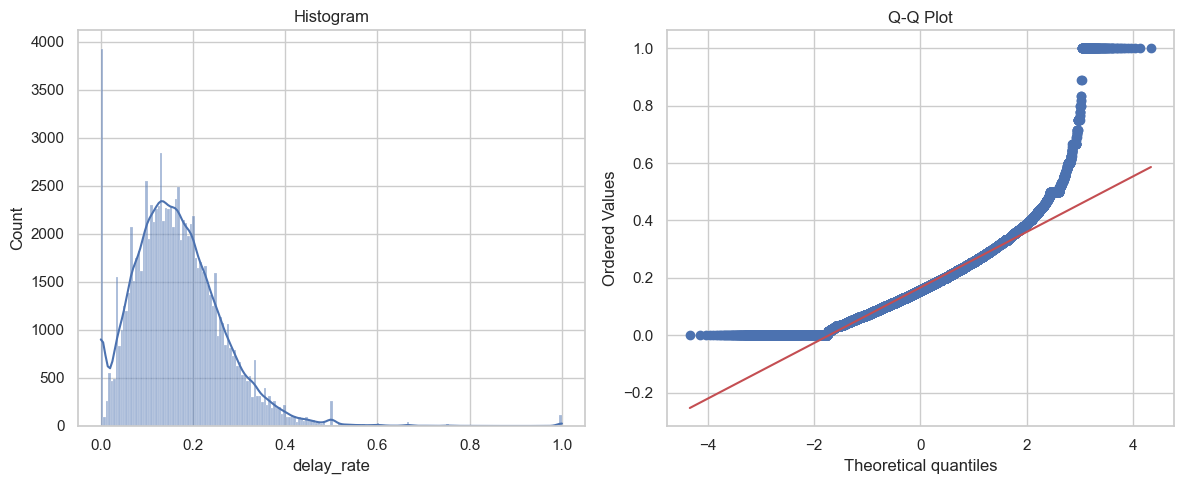

In [39]:
def check_target_distribution(y):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(y, kde=True)
    plt.title("Histogram")
    
    plt.subplot(1, 2, 2)
    stats.probplot(y, dist="norm", plot=plt)
    plt.title("Q-Q Plot")

    plt.tight_layout()
    plt.show()


check_target_distribution(y_train) 

As observed during EDA, the raw `delay_rate` exhibits high variance, particularly in observations with a low number of total flights (arr_flights). Small sample sizes lead to extreme target values (0.0 or 1.0), introducing noise that hinders the convergence of models.
To address this, we implemented Empirical Bayesian Smoothing (also known as shrinkage). This technique stabilizes the target variable by computing a weighted average between the raw observed rate and the global average delay rate The transformation is defined as:
$$
y_{\text{smoothed}} = \frac{n \cdot y_{\text{raw}} + k \cdot \mu_{\text{global}}}{n + k}
$$
Where:
* $y_{\text{raw}}$: The original delay rate for the specific observation

* $n$: The number of flights (`arr_flights`), representing the weight of the evidence

* $\mu_{\text{global}}$: The global mean delay rate across the entire training dataset

* $k$: The smoothing parameter (set to 50), which controls the strength of regularization

#### Evaluation Utilities

In [40]:
def plot_residuals(y_true, y_pred, model_name):

    residuals = y_true - y_pred
    
    _, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=axes[0])
    axes[0].axhline(0, color="red", linestyle="--", linewidth=2)
    axes[0].set_xlabel("Predicted Values")
    axes[0].set_ylabel("Residuals")
    axes[0].set_title(f"{model_name}: Residual Plot")

    sns.histplot(residuals, kde=True, ax=axes[1], color="orange")
    axes[1].set_title(f"{model_name}: Residuals Distribution")
    axes[1].set_xlabel("Residual Value")
    
    plt.tight_layout()
    plt.show()

def evaluate(model, preprocessor, X_train, y_train, X_val, y_val, model_name):

    pipe = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print(f"Results for {model_name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2:  {r2:.4f}")
    print(f"MAE:  {mae:.4f}\n")
    
    plot_residuals(y_val, y_pred, model_name)
    
    return {
        "Model": model_name,
        "RMSE": rmse,
        "R2": r2,
        "MAE": mae
    }

1. `evaluate`: A streamlined wrapper that fits the model pipeline on the training data and immediately evaluates it on the validation set. It calculates key metrics (RMSE, MAE, R2) to assess how well the model generalizes to unseen data

2.  **`plot_residuals`**: Visualizes the model's errors ($y_{true} - y_{pred}$) to diagnose performance:
* **Scatter Plot:** Reveals if the error magnitude changes depending on the predicted value
* **Histogram:** Shows the error distribution to check if the model is centered around zero or has a systematic bias


#### Raw Target

Results for Linear Regression (raw y)
RMSE: 0.1159
R^2:  -0.0160
MAE:  0.0815



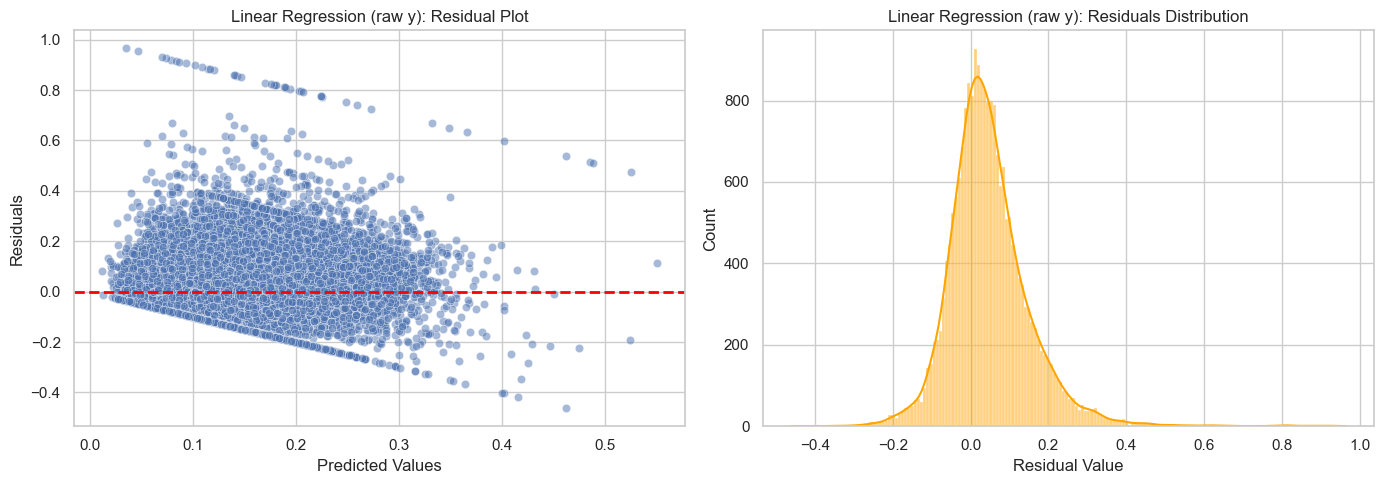

In [41]:
baseline_results = []
lin_reg = LinearRegression()
dec_tree = DecisionTreeRegressor(max_depth=2, random_state=RANDOM_STATE)

results = evaluate(lin_reg, linear_features, X_train, y_train, X_val, y_val, "Linear Regression (raw y)")
baseline_results.append(results)

Results for Decision Tree (raw y)
RMSE: 0.1109
R^2:  0.0701
MAE:  0.0784



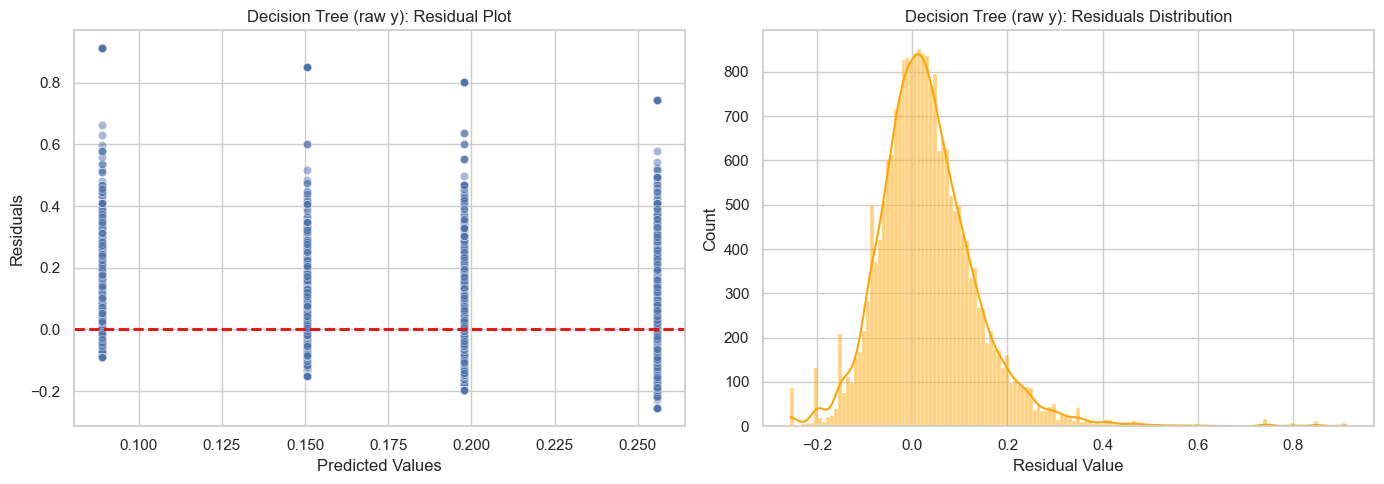

In [42]:
results = evaluate(dec_tree, tree_features, X_train, y_train, X_val, y_val, "Decision Tree (raw y)")
baseline_results.append(results)

Since the target `delay_rate` is bounded between 0 and 1, the residual plot naturally appears compressed, as the model cannot predict values outside this range

* **Linear Regression:** 
The residual plot's structural patterns and the negative R2 score confirm that a linear approach is insufficient for this dataset. This result aligns perfectly with the Pearson correlation analysis performed during EDA, which showed negligible linear relationships between the predictors and the target. The model failed to find a meaningful linear hyperplane, effectively performing worse than a simple mean baseline

* **Decision Tree (max_depth=2):** Restricting the tree depth to 2 yielded the optimal result for this model class ($R2≈0.07$), significantly outperforming deeper trees. Experiments showed that increasing depth beyond 2 causes immediate performance degradation (negative R2), indicating that the model begins to severely overfit to noise and feature correlations rather than capturing the true signal. The residual plot displays exactly 4 distinct vertical clusters (corresponding to the leaves of the shallow tree). The histogram shows a tighter peak around zero compared to linear regression, confirming better predictive power. However, the distribution is "jagged" or multi-modal, reflecting the discrete, step-wise nature of the model's predictions

#### Smoothed Target

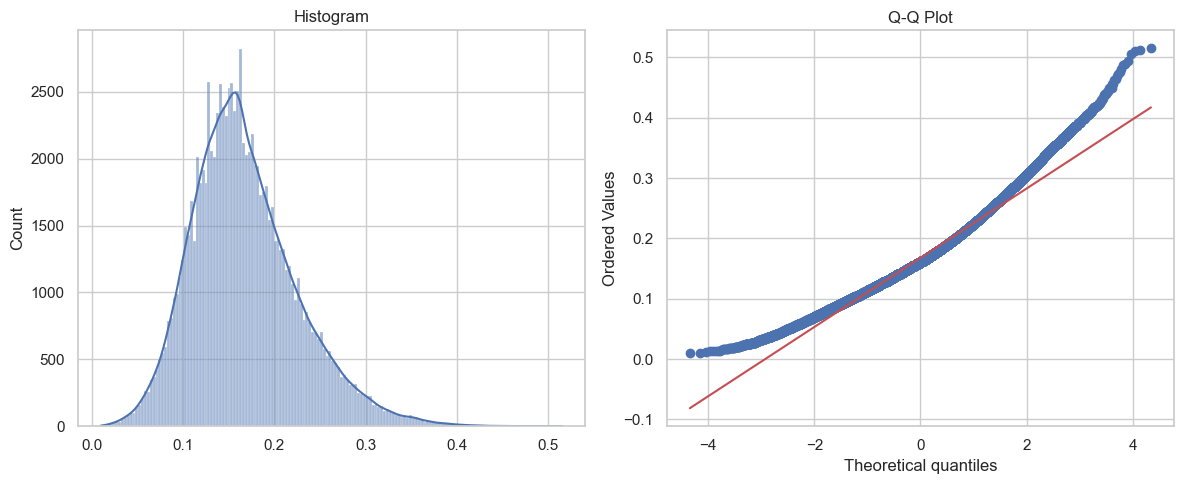

In [43]:
global_mean = y_train.mean()
n_flights_train = X_train["arr_flights"]
y_train_smooth = (y_train * n_flights_train + global_mean * 50) / (n_flights_train + 50)

check_target_distribution(y_train_smooth)

Applying the Empirical Bayesian smoothing transformation has successfully stabilized the variable. The histogram now exhibits a clear bell-shaped distribution, which is approximately symmetric. The Q-Q Plot strongly corroborates this finding, showing the data points closely hugging the theoretical normal line along most of the range

Results for Linear Regression (smoothed y)
RMSE: 0.1144
R^2:  0.0100
MAE:  0.0800



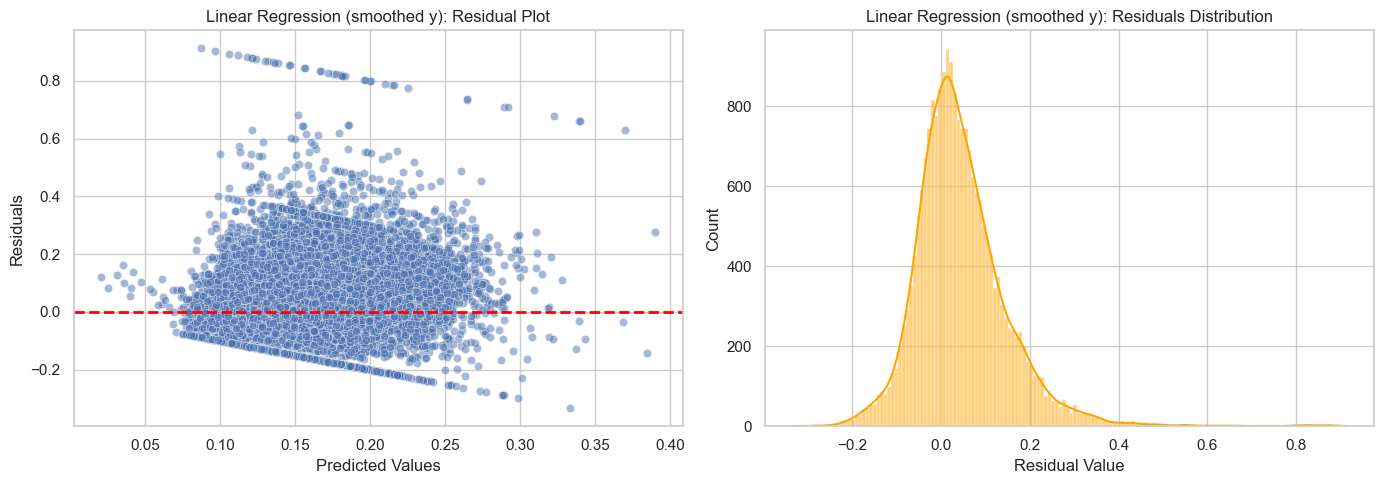

In [44]:
results = evaluate(lin_reg, linear_features, X_train, y_train_smooth, X_val, y_val, "Linear Regression (smoothed y)")
baseline_results.append(results)

Results for Decision Tree (smoothed y)
RMSE: 0.1140
R^2:  0.0174
MAE:  0.0799



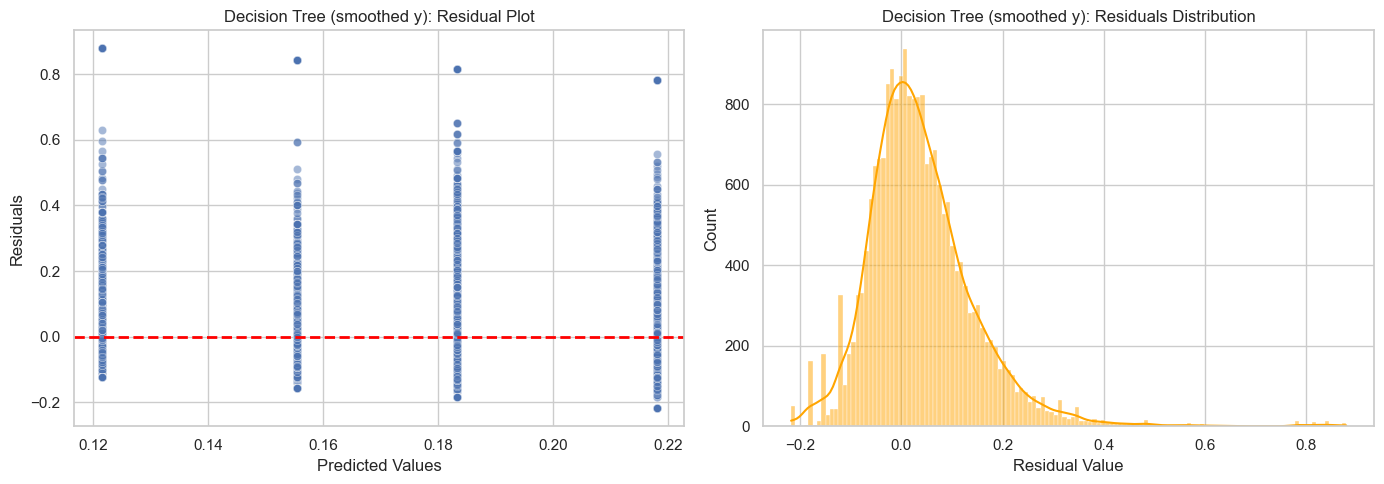

In [45]:
results = evaluate(dec_tree, tree_features, X_train, y_train_smooth, X_val, y_val, "Decision Tree (smoothed y)")
baseline_results.append(results)

In [46]:
baseline_results_df = pd.DataFrame(baseline_results)
baseline_results_df.sort_values(by="RMSE")

Model      RMSE        R2       MAE
1           Decision Tree (raw y)  0.110918  0.070099  0.078421
3      Decision Tree (smoothed y)  0.114018  0.017393  0.079874
2  Linear Regression (smoothed y)  0.114445  0.010011  0.079972
0       Linear Regression (raw y)  0.115937 -0.015964  0.081470

Applying Empirical Bayesian Smoothing (shrinkage) to the target variable acted as a noise-reduction filter. While the residual distributions remained largely unchanged visually, the impact on model performance was contrasting: the Linear Regression marginally benefited from outlier mitigation, while the shallow Decision Tree suffered from signal dampening

* **Linear Regression (Smoothed):** 
The smoothing process yielded a slight performance boost, lifting the R2 from negative values into positive territory (~0.01). By pulling extreme outliers closer to the global mean, the smoothing reduced the penalty for large errors, allowing the linear model to fit the average trend slightly better

* **Decision Tree (max_depth=2, Smoothed):** 
Unexpectedly, the performance of the shallow tree degraded compared to the raw target (dropping from $R2≈0.07$ to $0.017$). This suggests that for a highly constrained model (depth=2), the smoothing acted as over-regularization. Shallow trees rely on finding distinct "peaks" or groups with significantly different means. EBS "shrunk" these local differences towards the global average, effectively reducing the contrast between the leaves. The tree could no longer distinguish the high-value groups as clearly as it did with the raw data

**Conclusion:**

Based on the initial experiments, the raw target has been selected as the primary focus for further modeling. The analysis revealed that Empirical Bayesian Smoothing acted aggressively, "dampening" the signal and degrading the performance of non-linear models (Decision Tree R2 dropped from 0.07 to 0.017)
We hypothesize that advanced ensemble models (like Gradient Boosting) will benefit more from the full variance of the raw data, relying on their internal regularization to handle noise rather than pre-processing it away. However, to ensure rigorous validation, the final "champion" model will be benchmarked on both raw and smoothed targets

---

## 6. Model Benchmarking & Results

#### Utilities

In [47]:
all_model_results = []
scoring_metrics = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error' ,
    'r2': 'r2'
}

def fit_and_evaluate(model, param_dist, preprocessor, X, y, search_method, cv_strategy, model_name, n_iter=None, n_jobs=1):
    
    pipe = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])

    if search_method == "random":
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_dist,
            n_iter=n_iter,       
            cv=cv_strategy,
            scoring=scoring_metrics,
            refit="rmse",
            n_jobs=n_jobs,
            random_state=RANDOM_STATE,
            verbose=1
        )
    else:
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_dist,
            cv=cv_strategy,
            scoring=scoring_metrics,
            refit='rmse',
            n_jobs=n_jobs,
            verbose=1
        )

    search.fit(X, y)

    best_model = search.best_estimator_
    print(f"Best params: {search.best_params_}")

    best_idx = search.best_index_
    best_rmse = -search.cv_results_['mean_test_rmse'][best_idx] 
    best_mae = -search.cv_results_['mean_test_mae'][best_idx]   
    best_r2 = search.cv_results_['mean_test_r2'][best_idx]

    print(f"\nResults for {model_name}:")
    print(f"Best RMSE: {best_rmse:.4f}")
    print(f"Best R^2: {best_r2:.4f}")
    print(f"Best MAE: {best_mae:.4f}")

    return best_model, {
            "Model": model_name,
            "Best RMSE": best_rmse,
            "Best R^2": best_r2,
            "Best MAE": best_mae
        }

This utility function standardizes the model-training workflow. It builds a unified pipeline that combines preprocessing and the estimator, then performs hyperparameter optimization using either RandomizedSearchCV or GridSearchCV. Multiple evaluation metrics (MAE, RMSE, R^2) are computed via cross-validation or a predefined validation split, helping avoid data leakage. The function finally returns the best model (according to RMSE) along with its key performance metrics

In [48]:
X_combined = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_combined = pd.concat([y_train, y_val], axis=0, ignore_index=True)

split_index = [-1]*len(X_train) + [0]*len(X_val)
pds = PredefinedSplit(test_fold=split_index)

This code merges the training and validation sets into a single dataset and uses PredefinedSplit to explicitly mark which samples belong to the training fold and which to the validation fold. This enables the hyperparameter search to evaluate models strictly on the validation portion while training only on the training portion

#### **Polynomial Ridge Regression**

In [49]:
param_grid = {
    'model__linreg__alpha': [0.1, 1, 10, 100, 200, 300]
}

poly_lin_reg = Pipeline([
    ("poly", PolynomialFeatures(degree=2)),
    ("linreg", Ridge())
])

best_pol_lin_reg, results = fit_and_evaluate(
    model=poly_lin_reg, 
    X=X_combined, y=y_combined, 
    cv_strategy=pds,
    search_method="grid", 
    model_name="Polynomial Ridge Regression (degree 2)", 
    preprocessor=linear_features, 
    param_dist=param_grid,
    n_jobs=-1
)

all_model_results.append(results)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best params: {'model__linreg__alpha': 0.1}

Results for Polynomial Ridge Regression (degree 2):
Best RMSE: 0.1059
Best R^2: 0.1524
Best MAE: 0.0741


**Analysis:**

Despite introducing polynomial features, the model shows limited predictive power with an $R^2$ of only 0.152. The selection of a minimal alpha (0.1) indicates that the model is underfitting and struggles to capture the underlying patterns. This confirms the need for more complex, non-linear algorithms

#### **K-Nearest Neighbors**

In [51]:
param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15, 20, 25],
    "model__weights": ['uniform', 'distance'],
    "model__p": [1, 2]
}

knr = KNeighborsRegressor()

best_knr, results = fit_and_evaluate(
    model=knr,
    X=X_combined, y=y_combined,
    cv_strategy=pds,
    search_method="grid",
    model_name="K-Neighbors Regressor",
    preprocessor=knn_features,
    param_dist=param_grid,
    n_jobs=-1
)

all_model_results.append(results)

Fitting 1 folds for each of 32 candidates, totalling 32 fits
Best params: {'model__n_neighbors': 25, 'model__p': 1, 'model__weights': 'distance'}

Results for K-Neighbors Regressor:
Best RMSE: 0.1186
Best R^2: -0.0636
Best MAE: 0.0833


**Analysis:**

The K-Neighbors Regressor performed significantly worse than the linear baseline, yielding a negative $R^2$ score of -0.06. This result illustrates the "curse of dimensionality", where distance-based metrics lose effectiveness given the high number of features (35). Even though the grid search maximized the number of neighbors (k=25) and applied distance weighting to mitigate noise, the model failed to generalize better than a simple mean predictor, confirming that spatial distance is not a reliable metric for this dataset

#### **Random Forest**

In [ ]:
param_grid = {
    "model__n_estimators": stats.randint(100, 500),
    "model__max_depth": [10, 15, 20, 30, None],
    "model__max_features": ['sqrt'],
    "model__min_samples_leaf": stats.randint(1, 10),
    "model__min_samples_split": stats.randint(2, 15)
}

rf = RandomForestRegressor(random_state=RANDOM_STATE)

_, _ = fit_and_evaluate(
    model=rf,
    X=X_combined, y=y_combined,
    cv_strategy=pds,
    search_method="random",
    model_name="Random Forest",
    preprocessor=tree_features,
    param_dist=param_grid,
    n_iter=10,
    n_jobs=-1
)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 430}

Results for Random Forest:
Best RMSE: 0.1095
Best R^2: 0.0934
Best MAE: 0.0754


In [ ]:
param_grid = {
    "model__n_estimators": [400, 500, 650],
    "model__max_depth": [11, 13, 15],
    "model__max_features": ['sqrt'],
    "model__min_samples_leaf": [2, 3, 4],
    "model__min_samples_split": [5, 8, 10]
}

rf = RandomForestRegressor(random_state=RANDOM_STATE)

best_rf, results = fit_and_evaluate(
    model=rf,
    X=X_combined, y=y_combined,
    cv_strategy=pds,
    search_method="grid",
    model_name="Random Forest",
    preprocessor=tree_features,
    param_dist=param_grid,
    n_jobs=-1
)

all_model_results.append(results)

Fitting 1 folds for each of 81 candidates, totalling 81 fits
Best params: {'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 8, 'model__n_estimators': 400}

Results for Random Forest:
Best RMSE: 0.1085
Best R^2: 0.1103
Best MAE: 0.0746


**Analysis:**

Performance overview the Random Forest model achieved an RMSE of 0.108 and an R^2 of 0.110. While this outperforms the baseline metrics, the model struggled to capture the signal effectively, showing signs of overfitting to local noise rather than learning generalizable patterns

As it turned out in EDA the primary challenge in this dataset is the high variance within specific features, such as airports with low traffic volume, being a low-bias/high-variance algorithm, the random forest aggressively splits on these sparse features, attempting to minimize error by isolating these specific outlier cases in leaf nodes, so instead of learning the global trend, the trees essentially "memorized" the statistical noise generated by small sample sizes in the categorical features

This analysis explains why the simpler Polynomial Ridge Regression outperformed the ensemble ($R2≈0.152$ vs $0.110$). While the random forest got distracted by the extreme values of small airports, the Ridge Regression (with L2 regularization) treated these deviations as noise. linear model's rigidity prevented it from overfitting to sparse anomalies, allowing it to capture the underlying global trend better than the more complex non-linear approach. In this specific case, model simplicity provided better robustness against data noise

#### **XGBoost**

In [ ]:
param_grid = {
    "model__n_estimators": stats.randint(150, 300),
    "model__learning_rate": stats.uniform(0.01, 0.49),
    "model__max_depth": stats.randint(3, 10),
    "model__subsample": stats.uniform(0.4, 0.6),
    "model__colsample_bytree": stats.uniform(0.4, 0.6),
    "model__reg_alpha": stats.uniform(0, 1),
    "model__reg_lambda": stats.uniform(0, 1)
}

xgb = XGBRegressor(random_state=RANDOM_STATE)

_, _ = fit_and_evaluate(
    model=xgb,
    X=X_combined, y=y_combined,
    cv_strategy=pds,
    search_method="random",
    model_name="XGBoost",
    preprocessor=tree_features,
    param_dist=param_grid,
    n_iter=250,
    n_jobs=-1
)

Fitting 1 folds for each of 250 candidates, totalling 250 fits
Best params: {'model__colsample_bytree': 0.8627480011118428, 'model__learning_rate': 0.1934733311630068, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__reg_alpha': 0.7364442356247228, 'model__reg_lambda': 0.9343670147690148, 'model__subsample': 0.9553411077440658}

Results for XGBoost:
Best RMSE: 0.1013
Best R^2: 0.2250
Best MAE: 0.0701


In [ ]:
param_grid = {
    "model__n_estimators": [200, 300, 350, 450],
    "model__learning_rate": [0.06, 0.1, 0.2, 0.5],
    "model__max_depth": [2, 3, 5],
    "model__subsample": [0.6, 0.8],
    "model__colsample_bytree": [0.4, 0.5, 0.7],
    "model__reg_alpha": [0.7, 1, 2],
    "model__reg_lambda": [0.01, 0.1, 0.2]
}

xgb = XGBRegressor(random_state=RANDOM_STATE)

best_xgb, results = fit_and_evaluate(
    model=xgb,
    X=X_combined, y=y_combined,
    cv_strategy=pds,
    search_method="grid",
    model_name="XGBoost",
    preprocessor=tree_features,
    param_dist=param_grid,
    n_jobs=-1
)

all_model_results.append(results)

Fitting 1 folds for each of 2592 candidates, totalling 2592 fits
Best params: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.5, 'model__max_depth': 2, 'model__n_estimators': 450, 'model__reg_alpha': 0.7, 'model__reg_lambda': 0.1, 'model__subsample': 0.8}

Results for XGBoost:
Best RMSE: 0.1010
Best R^2: 0.2289
Best MAE: 0.0697


**Analysis:**

XGBoost demonstrated strong performance with an RMSE of 0.1010 and an R^2 of 0.229, showing a massive improvement over the Random Forest and Polynomial Regression. Notably, the model selected extremely shallow trees `max_depth=2` combined with a high `learning rate=0.5`, indicating that the most effective strategy for this noisy dataset is to iteratively correct simple errors rather than building complex, deep decision boundaries that risk overfitting

#### **CatBoost**

In [52]:
param_grid = {
    "model__iterations": [100, 150, 200, 250],
    "model__depth": [3, 5, 7],
    "model__bagging_temperature": [0, 1],
}

cat_features = [0, 1]

catboost = CatBoostRegressor(
    cat_features=cat_features, 
    logging_level='Silent', 
    task_type="GPU", 
    devices="0",
    random_state=RANDOM_STATE
)

best_catboost, results = fit_and_evaluate(
    model=catboost,
    X=X_combined, y=y_combined,
    cv_strategy=pds,
    search_method="grid",
    model_name="CatBoost",
    preprocessor=catboost_features,
    param_dist=param_grid,
    n_jobs=1
)

all_model_results.append(results)

Fitting 1 folds for each of 24 candidates, totalling 24 fits
Best params: {'model__bagging_temperature': 0, 'model__depth': 3, 'model__iterations': 100}

Results for CatBoost:
Best RMSE: 0.1007
Best R^2: 0.2336
Best MAE: 0.0696


**Analysis:**

CatBoost emerged as the top-performing model, slightly edging out XGBoost with the best overall RMSE of 0.1007 and $R^2$ of 0.234. Similar to the other boosting model, it also favored shallow trees `depth=3`, reinforcing the conclusion that the dataset contains significant noise where increased model complexity fails to yield better generalization. The convergence of results between the top algorithms suggests we have hit a hard performance ceiling for the current feature set, and further hyperparameter tuning would likely offer diminishing returns

#### Hypothesis Testing: Target Smoothing

Results for CatBoost (Raw)
RMSE: 0.1007
R^2:  0.2336
MAE:  0.0696



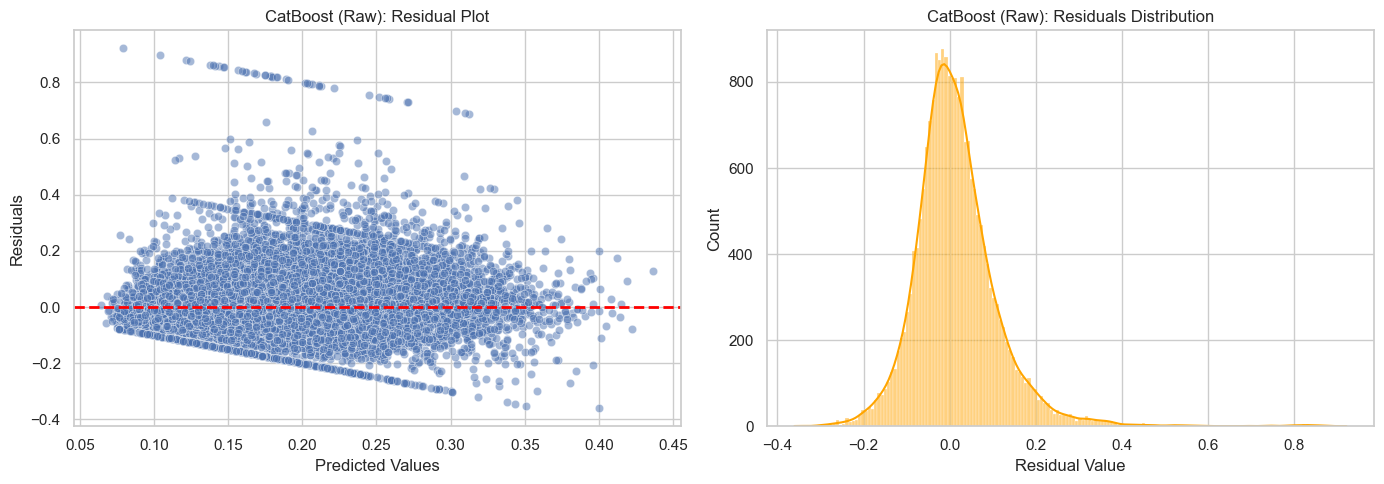

In [ ]:
_ = evaluate(best_catboost, "passthrough", X_train, y_train, X_val, y_val, "CatBoost (Raw)")

Results for CatBoost (Smoothed)
RMSE: 0.1072
R^2:  0.1313
MAE:  0.0738



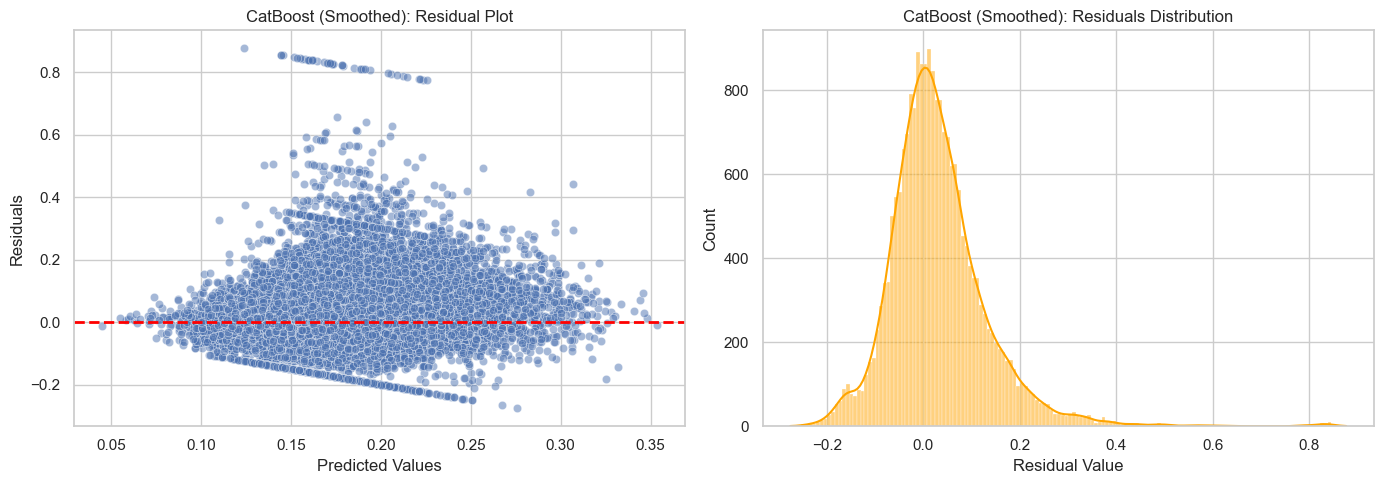

In [ ]:
_ = evaluate(best_catboost, "passthrough", X_train, y_train_smooth, X_val, y_val, "CatBoost (Smoothed)")

**Conclusion**

The experiment demonstrated that smoothing the target variable significantly degraded model performance instead of improving it. The $R^2$ score dropped from 0.2336 on the raw target to 0.1313 on the smoothed target. Furthermore, the histogram reveals that the smoothed target actually exhibits a wider spread (higher variance) compared to the raw data, suggesting that the transformation distorted the signal rather than reducing noise. Consequently, we reject the hypothesis and will proceed with the raw target for the final modeling

In [ ]:
all_model_results_df = pd.DataFrame(all_model_results)
all_model_results_df = all_model_results_df.sort_values(by="Best R^2", ascending=False).reset_index().drop(["index"], axis=1)
all_model_results_df

Model  Best RMSE  Best R^2  Best MAE
0                                CatBoost   0.100693  0.233638  0.069573
1                                 XGBoost   0.101004  0.228889  0.069681
2  Polynomial Ridge Regression (degree 2)   0.105896  0.152387  0.074091
3                           Random Forest   0.108491  0.110337  0.074628
4                   K-Neighbors Regressor   0.118626 -0.063635  0.083342

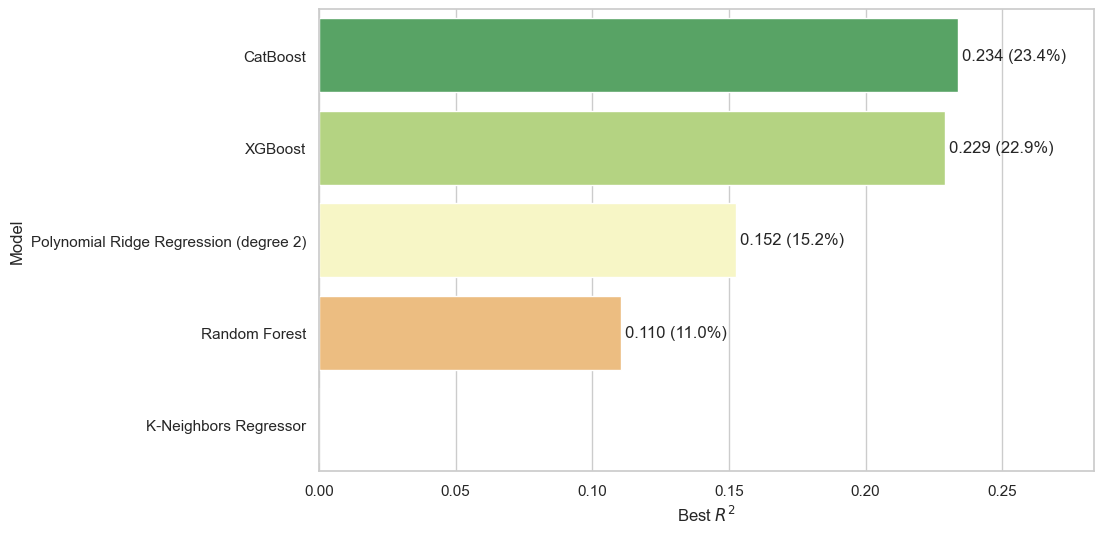

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=all_model_results_df, x="Best R^2", y="Model", palette="RdYlGn_r", hue="Model", legend=False)
for container in ax.containers:
    labels = [f"{bar.get_width():.3f} ({bar.get_width():.1%})" for bar in container]
    ax.bar_label(container, labels=labels, padding=3)

plt.xlabel("Best $R^2$", fontsize=12) 
plt.ylabel("Model", fontsize=12)
plt.xlim(0, max(all_model_results_df["Best R^2"])+0.05)
plt.show()

**Final Model Selection & Conclusion**

After evaluating five distinct algorithms and conducting target engineering experiments, we have identified the optimal modeling strategy and analyzed the intrinsic limits of the dataset

1. **The Champion: CatBoost**

    CatBoost achieved the highest performance with an RMSE of 0.1007 and an $R^2$ of 0.234, marginally outperforming XGBoost ($R^2≈0.229$). The CatBoost effectively handled the categorical features and managed the data noise better than Random Forest by utilizing shallow, iterative trees to capture subtle dependencies without overfitting

2. **Comparative Analysis**

    The model comparison revealed crucial insights into the nature of the data:
    * **The "Curse of Dimensionality" (KNN Failure):** The K-Neighbors Regressor failed significantly ($R^2=−0.06$). With 35 features, the data points became too sparse for distance-based metrics (Euclidean) to be effective. Even with optimized weights, the model could not generalize better than a simple mean predictor

    * **Simplicity vs. Complexity (Poly Regression > Random Forest):** Surprisingly, the simpler Polynomial Ridge Regression ($R^2≈0.152$) outperformed the Random Forest ($R2≈0.110$). The Random Forest, being a high-variance algorithm, aggressively split on sparse features (e.g., small airports with extreme delay rates), effectively memorizing statistical noise. In contrast, Ridge Regression’s L2 regularization treated these deviations as noise, and the rigidity of the linear model prevented overfitting, showing that for this specific dataset robust simplicity was superior to unregularized complexity


3. **Hypothesis Rejection: Target Smoothing:**

    It was initially hypothesized that more complex models, such as gradient boosting, would benefit more from target smoothing than a single decision tree. However, the results did not support this assumption: the $R^2$ score dropped from 0.2336 (raw target) to 0.1313 (smoothed target). Histogram analysis revealed that smoothing increased variance rather than reducing it. The transformation distorted the underlying signal, leading to the rejection of the hypothesis and the decision to proceed with the raw target

4. **The Performance Ceiling & EDA Validation**

    We observe a clear performance plateau, which aligns perfectly with our initial Exploratory Data Analysis (EDA)

    * **Correlation & Depth:** The Pearson matrix showed no linear relationship, and the Spearman matrix indicated only weak non-linear associations. This is confirmed by the fact that our top models (XGBoost/CatBoost) converged on extremely shallow trees (depth 2-3). Deep trees immediately led to overfitting. 

    So we have reached the intrinsic limit of the current feature set. Further hyperparameter tuning will yield diminishing returns. To significantly improve metrics beyond $R2≈0.23$, the focus must shift from model-centric optimization to data-centric improvements (e.g., acquiring external features like real-time weather logs or air traffic data)


---

## 7. Final Evaluation on Test Set

### 7.1 Learning Curve

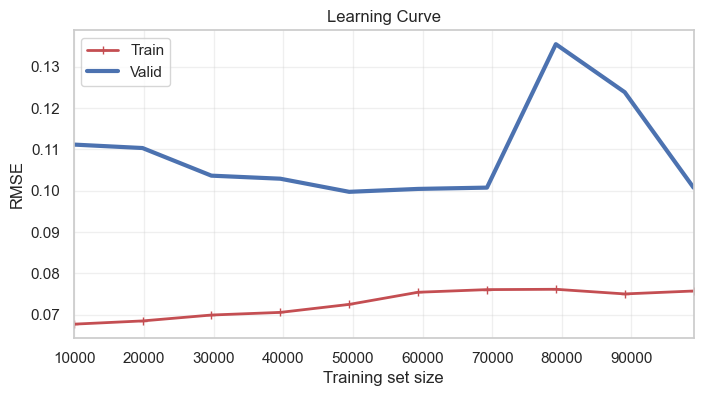

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=best_catboost, X=X_combined, y=y_combined, train_sizes=np.linspace(0.1, 1.0, 10), cv=pds,
    scoring="neg_root_mean_squared_error")

train_erros = -train_scores.mean(axis=1)
valid_erros = -valid_scores.mean(axis=1)

plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_erros, "r-+", linewidth=2, label="Train")
plt.plot(train_sizes, valid_erros, "b-", linewidth=3, label="Valid")
plt.title("Learning Curve")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.xlim(train_sizes[0], train_sizes[-1])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The visualization confirms the high variance inherent in the model, evidenced by the persistent gap between training and validation RMSE. The validation curve plateaus after 50,000 samples, indicating that simply adding more data of the same quality will not improve performance. Additionally, the sharp error spike around 80,000 samples highlights the model's sensitivity to specific noisy batches (outliers), further validating the necessity for high-bias, shallow trees to maintain stability

### 7.2 Performance Analysis

Final test RMSE: 0.1021
Final test R^2: 0.2130
Final test MAE: 0.0720


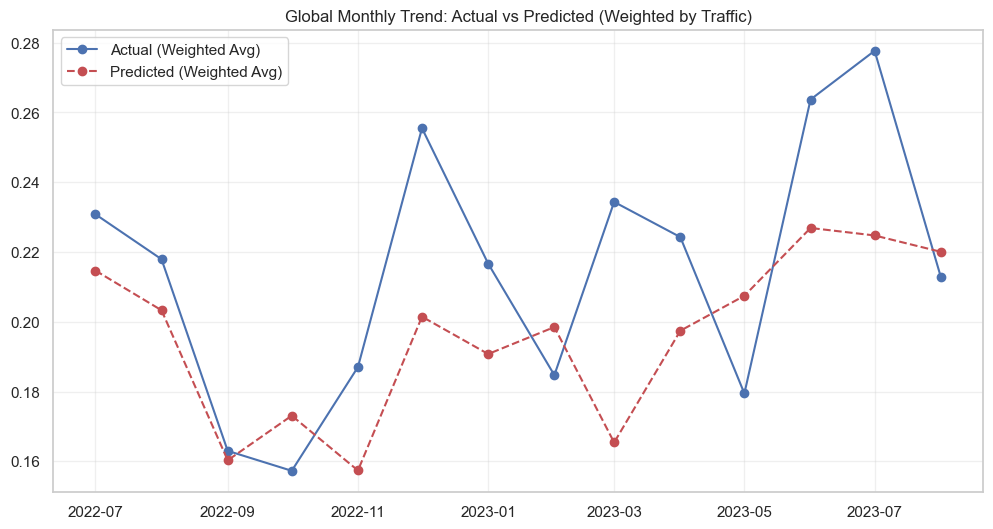

In [ ]:
final_preds = best_catboost.predict(X_test)
print(f"Final test RMSE: {np.sqrt(mean_squared_error(y_test, final_preds)):.4f}")
print(f"Final test R^2: {r2_score(y_test, final_preds):.4f}")
print(f"Final test MAE: {mean_absolute_error(y_test, final_preds):.4f}")

result_df = X_test.copy()
result_df["Actual"] = y_test
result_df["Predicted (CatBoost)"] = final_preds

result_df["Date"] = pd.to_datetime(result_df[["year", "month"]].assign(day=1))

def weighted_avg(df, values, weights):
    return sum(df[values] * df[weights]) / sum(df[weights])

monthly_stats = result_df.groupby("Date").apply(
    lambda x: pd.Series({
        "Actual_weighted": weighted_avg(x, "Actual", "arr_flights"),
        "Predicted_weighted": weighted_avg(x, "Predicted (CatBoost)", "arr_flights")
    }), include_groups=False 
)

plt.figure(figsize=(12, 6))
plt.plot(monthly_stats.index, monthly_stats["Actual_weighted"], "b-o", label="Actual (Weighted Avg)")
plt.plot(monthly_stats.index, monthly_stats["Predicted_weighted"], "r--o", label="Predicted (Weighted Avg)")
plt.title("Global Monthly Trend: Actual vs Predicted (Weighted by Traffic)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

To evaluate the model's performance on the noisy test set, we aggregated the predictions by month using a traffic-weighted average. Since small airports with low flight volumes exhibit extreme variance (often hitting 0% or 50% delay rates randomly), averaging based on flight volume allows us to filter out this noise and visualize the true macro-trends of the aviation network.

The resulting plot reveals that the model has high directional accuracy: it correctly identifies major market shifts, such as the dip in Autumn 2022 and the subsequent rise towards Summer 2023. However, we observe a clear conservative bias. While the model captures the timing of the spikes (like the March 2023 anomaly), it underestimates their magnitude. This "damping effect" occurs because the model is optimized to minimize RMSE, leading it to predict safe, expected averages rather than chasing extreme, high-risk outliers

### 7.3 SHAP Analysis

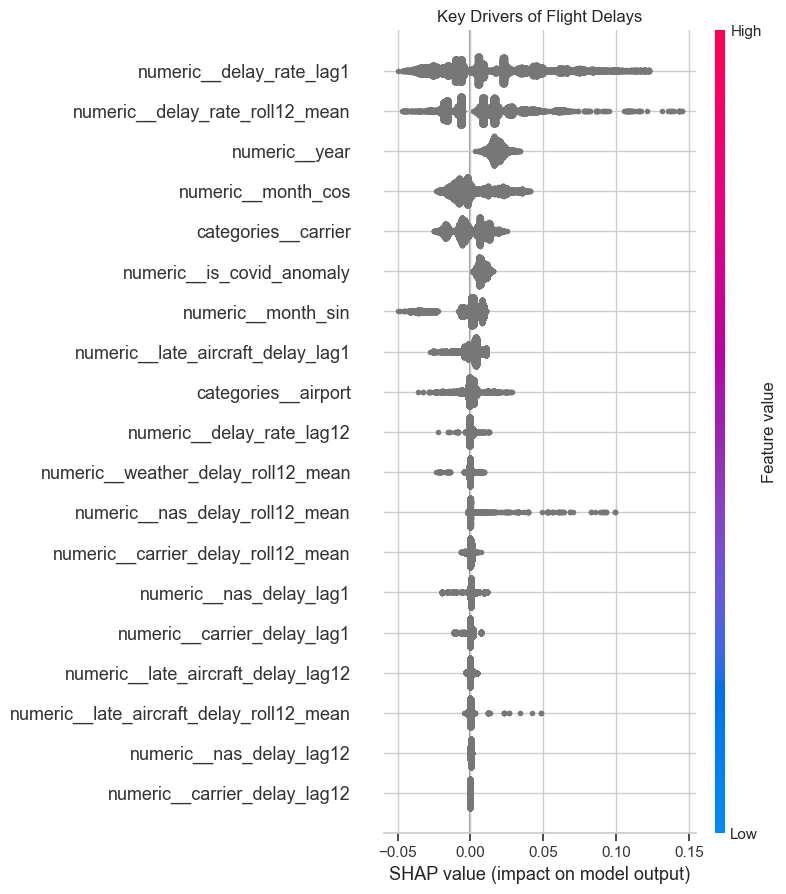

In [53]:
actual_model = best_catboost.named_steps["model"]
preprocessor = best_catboost.named_steps["preprocessing"]

X_test_transformed = preprocessor.transform(X_test)
feature_names = None

try:
    feature_names = preprocessor.get_feature_names_out()
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
except:
    pass

explainer = shap.TreeExplainer(actual_model)
shap_values = explainer.shap_values(X_test_transformed) 

plt.title("Key Drivers of Flight Delays")
shap.summary_plot(shap_values, X_test_transformed, show=False)
plt.show()

To interpret the "black box" decisions of our CatBoost model, we utilize SHAP (SHapley Additive exPlanations) values. Instead of merely ranking features by importance, this method quantifies the marginal contribution of each variable to the final prediction. This allows us to understand the direction of impact (does a feature increase or decrease delay?) and identify which factors the model actually relies on versus those it ignores

The summary plot reveals that the system is fundamentally inertial: the previous month's performance (`delay_rate_lag1`) is the single most dominant predictor, far outweighing other variables. We also observe significant feature redundancy: specific causes like weather_delay or nas_delay show surprisingly low importance. This occurs because their signal is already "absorbed" by the aggregate lag feature. Essentially, the model finds it more reliable to predict the future based on the total past delay rather than trying to parse noisy individual components

**Conclsuion**

We have performed a comprehensive evaluation of the CatBoost model, analyzing its learning dynamics, predictive bias, and feature reliance. The results confirm the model's ability to capture macro-trends while highlighting specific architectural trade-offs regarding sensitivity and inertia

* **Model Diagnosis & Stability**
    * The visualization confirms high variance in the model, evidenced by the persistent gap between training and validation RMSE
    * The validation curve plateaus after 50,000 samples, indicating that data volume is no longer the bottleneck; instead, structural changes (shallow trees) are required to handle sensitivity to noisy outliers

* **Predictive Performance**
    * By applying traffic-weighted averaging, we successfully filtered out the stochastic noise from small airports to reveal true network trends
    * The model exhibits high directional accuracy, correctly identifying major market shifts (e.g., the Autumn 2022 dip and Summer 2023 rise)
    * A distinct conservative bias is observed: while the model captures the timing of anomalies, the RMSE optimization causes a "damping effect," leading it to underestimate the magnitude of extreme spikes

* **Interpretability (SHAP Analysis)**
    * The system is fundamentally inertial: the previous month's performance (`delay_rate_lag1`) is the dominant predictor, far outweighing other variables
    * There is significant feature redundancy, as specific signals like `numeric_nas_delay_lag12` are absorbed by the aggregate lag feature. The model prioritizes the total past delay over parsing individual root causes

---

## 8. Final Project Conclusion

### 8.1 Executive Summary

In this project, we successfully developed a Machine Learning pipeline to predict flight delay rates across the US domestic aviation network (2013-2023). By analyzing over 170,000 observations, we validated the hypothesis that while flight delays are highly stochastic, they possess a predictable systemic component driven by seasonality, past performance inertia, and carrier-specific efficiency.

The CatBoost Regressor emerged as the champion model, achieving an RMSE of 0.1007 and an $R^2$ of ~0.234. While the coefficient of determination suggests a moderate fit, our analysis confirms that we have reached the intrinsic theoretical limit of predictability for the current dataset, where further model complexity yields diminishing returns

### 8.2 Data Characteristics & Predictability Limits

Exploratory Data Analysis confirmed the absence of meaningful linear relationships and revealed that delay behavior is primarily non-linear, seasonal, and inertial in nature. The presence of the funnel effect, where variance decreases with traffic volume while the median delay rate remains stable across airport sizes, highlighted that much of the observed volatility is statistical rather than structural. The COVID-19 period was identified as a clear exogenous regime shift, justifying explicit anomaly modeling rather than naive temporal smoothing.

Due to the inherently non-linear structure of the data, linear models proved ineffective. Although second-degree polynomial regression was able to explain approximately 15% of the variance, it required strong regularization to avoid overfitting, highlighting its limited expressive capacity.The K-Nearest Neighbors model exhibited a negative $R^2$ score, clearly illustrating the curse of dimensionality in a high-dimensional feature space

Random Forest performed poorly in this setting. As a high-variance ensemble that relies on deep trees and variance reduction through averaging, it aggressively overfit sparse and noisy categorical splits, with performance deteriorating rapidly for tree depths beyond 15.

In contrast, gradient boosting models (XGBoost and CatBoost) demonstrated superior generalization. Both converged to shallow tree structures (depth 2–3), indicating that iterative correction of simple decision rules is the most effective strategy for extracting signal from this noisy dataset. Nevertheless, even these models reached a clear performance plateau: the RMSE could not be reduced below 0.10, and the maximum explained variance remained limited to approximately 23%.

### 8.3 Effectiveness of Feature Engineering Strategy

Feature engineering decisions were directly derived from these findings. Cyclical encodings captured seasonal periodicity, lag-based features encoded temporal inertia, and rolling statistics extracted long-term trends while minimizing leakage. All future-peeking variables were removed to preserve strict chronological integrity.

Target smoothing via Empirical Bayesian Shrinkage was empirically shown to degrade performance, demonstrating that variance reduction at the target level suppressed meaningful signal rather than eliminating noise. This result reinforces the conclusion that robust models with internal regularization outperform aggressive pre-processing in this domain.

### 8.4 Interpretability of Final Model

Interpretability analysis using SHAP values confirmed that the system is fundamentally inertial: past delay behavior is the dominant driver of future delays, subsuming the influence of individual delay causes. This explains both the model’s strong directional accuracy and its conservative bias toward mean predictions, particularly under RMSE optimization.

Overall, this work establishes that the observed performance plateau ($R^2 ~0.23$) represents an intrinsic limit imposed by the available feature set rather than a modeling deficiency. Meaningful improvements beyond this threshold will require data-centric enhancements—such as high-resolution weather data, network-level traffic dependencies, or real-time operational signals—rather than further algorithmic tuning.

### 8.5 Business Value 

The model demonstrates high directional accuracy. It successfully predicts macro-trends (e.g., seasonal spikes in Summer/December) and identifies periods of network stress. It serves as a reliable baseline for capacity planning and risk assessment.

As evidenced by the residuals analysis and test set visualization, the model exhibits a conservative bias. Optimized for RMSE, it tends to predict the "safe average" and systematically underestimates the magnitude of extreme events. It predicts the risk of delay well, but not the severity of catastrophic collapses.

### **Final Verdict**

In conclusion, the analysis validates that while flight delays are largely stochastic, a constrained yet reliable predictive structure exists. When approached with disciplined modeling choices and realistic expectations, this signal can be extracted consistently, but not exceeded, confirming both the strengths and the fundamental limits of machine learning in this domain

---

### ✈️ Safe Travels!

Thank you for flying through this notebook with me.
While we can't control the weather or traffic, hopefully, this analysis gave you a better understanding of why we wait at the gate.